In [47]:
import os

import pandas as pd
import torch
import pickle

import matplotlib.pyplot as plt
from configs.enums import NormalizationType
from src import models, datasets, visualization

from torch.utils.data import DataLoader

In [31]:
fixed_path = "C:\\Users\\JanFiszer\\data\\fixed_test"
selected_one_for_df = "C:\\Users\\JanFiszer\\data\\one_for_ds"

In [32]:
selected_loaders = {}
images_dict = {}
targets_dict = {}

for selected_dir in os.listdir(selected_one_for_df):
    selected_path = os.path.join(selected_one_for_df, selected_dir)
    testset = datasets.MRIDatasetNumpySlices([selected_path])
    dataloader = DataLoader(testset, batch_size=1)
    images_dict[selected_dir], targets_dict[selected_dir] = next(iter(dataloader))

In [45]:
def get_evaluation_metrics(model_dir):
    eval_files = [filename for filename in os.listdir(model_dir) if "test_" in filename]

    eval_metrics = {}

    for filename in eval_files:
        filepath = os.path.join(model_dir, filename)

        test_set_name = filename[5:-14]
        with open(filepath, 'rb') as file:
            eval_metrics[test_set_name] = pickle.load(file)

    return eval_metrics

In [33]:
images = list(images_dict.values())
targets = list(targets_dict.values())

In [34]:
def pred_on_different_ds(unet):
    return [unet(input_img).detach() for input_img in images]

def personalized_model_pred(model_dir):
    client_dirs = [directory for directory in os.listdir(model_dir) if "client" in directory]

    predictions = []
    for dir_name, img in images_dict.items():
        for client_dir in client_dirs:
            if dir_name in client_dir:

                client_model_path = os.path.join(model_dir, client_dir, "model.pth")
                unet = models.UNet(normalization=config_train.NormalizationType.BN)
                unet.load_state_dict(torch.load(client_model_path, map_location=torch.device('cpu')))

                print(f"For model loaded from {client_model_path} and image from {dir_name}")

                predictions.append(unet(img).detach())

    return predictions

In [35]:
client_names = ["Client MGH", "Client WU MINN", "Client HGG", "Client LGG", "Client Oasis"]
plot_labels = ["Input", "Target", "Predicted"]
datasets_labels = list(images_dict.keys())

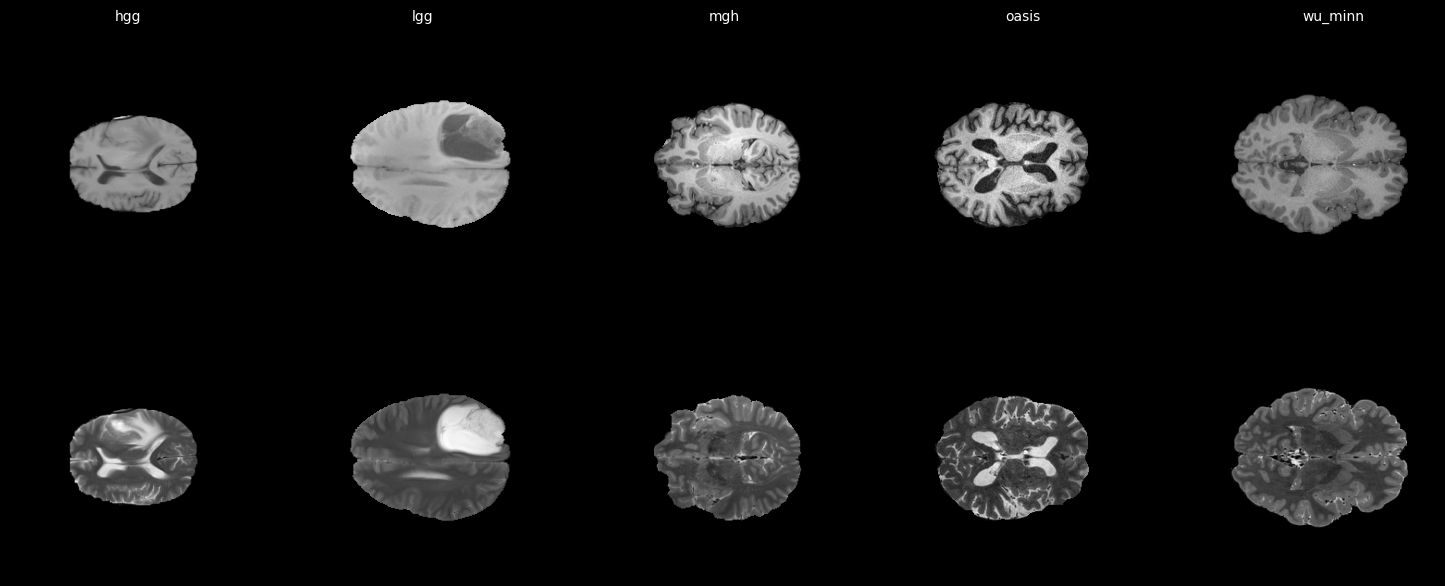

In [36]:
visualization.plot_pred([images, targets], datasets_labels, pad=1)

In [38]:
def plot_history(network_history):
    epochs = range(len(network_history["loss"]))

    fig, axs = plt.subplots(2, 2, figsize=(20, 15))

    axs[0,0].set_xlabel('Epochs')
    axs[0,0].set_ylabel('Loss')
    axs[0,0].plot(epochs, network_history['loss'])
    axs[0,0].plot(epochs, network_history['val_loss'])

    axs[1,0].set_xlabel('Epochs')
    axs[1,0].set_ylabel('SSIM')
    axs[1,0].plot(epochs, network_history['ssim'])
    axs[1,0].plot(epochs, network_history['val_ssim'])

    axs[1,1].set_xlabel('Epochs')
    axs[1,1].set_ylabel('MSE')
    axs[1,1].plot(epochs, network_history['mse'])
    axs[1,1].plot(epochs, network_history['val_mse'])

    axs[0,1].set_xlabel('Epochs')
    axs[0,1].set_ylabel('PNSR')
    axs[0,1].plot(epochs, network_history['pnsr'])
    axs[0,1].plot(epochs, network_history['val_pnsr'])

    plt.legend(['Training', 'Validation'])
    plt.show()

# Batch Normalization

## HGG

In [39]:
model_dir = "../trained_models/centralized-final/model-hgg_50-centralized-MSE_DSSIM-ep32-lr0.001-BN-2023-09-22-16h"

In [40]:
with open(f"{model_dir}/history.pkl", 'rb') as f:
    history = pickle.load(f)

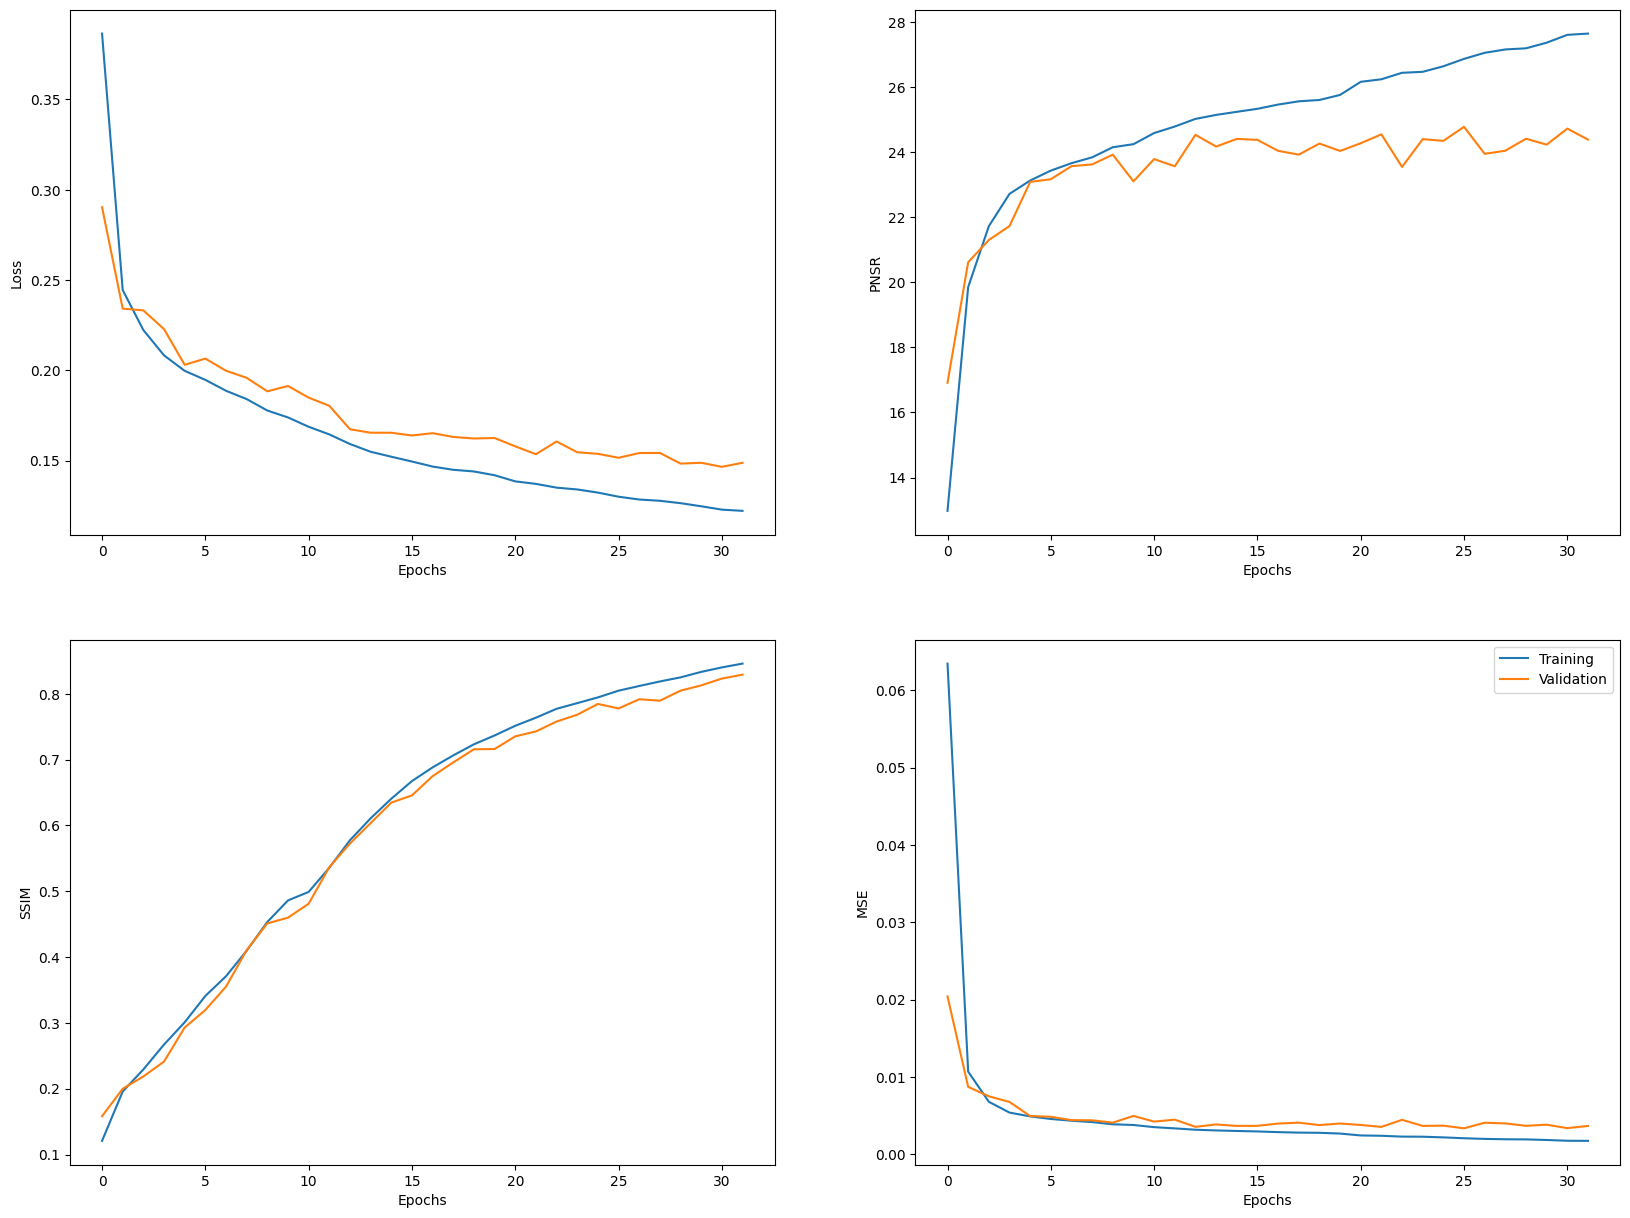

In [17]:
plot_history(history)

In [42]:
unet = models.UNet(normalization=NormalizationType.BN)
unet.load_state_dict(torch.load(f"{model_dir}/model.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [43]:
hgg_predictions = pred_on_different_ds(unet)

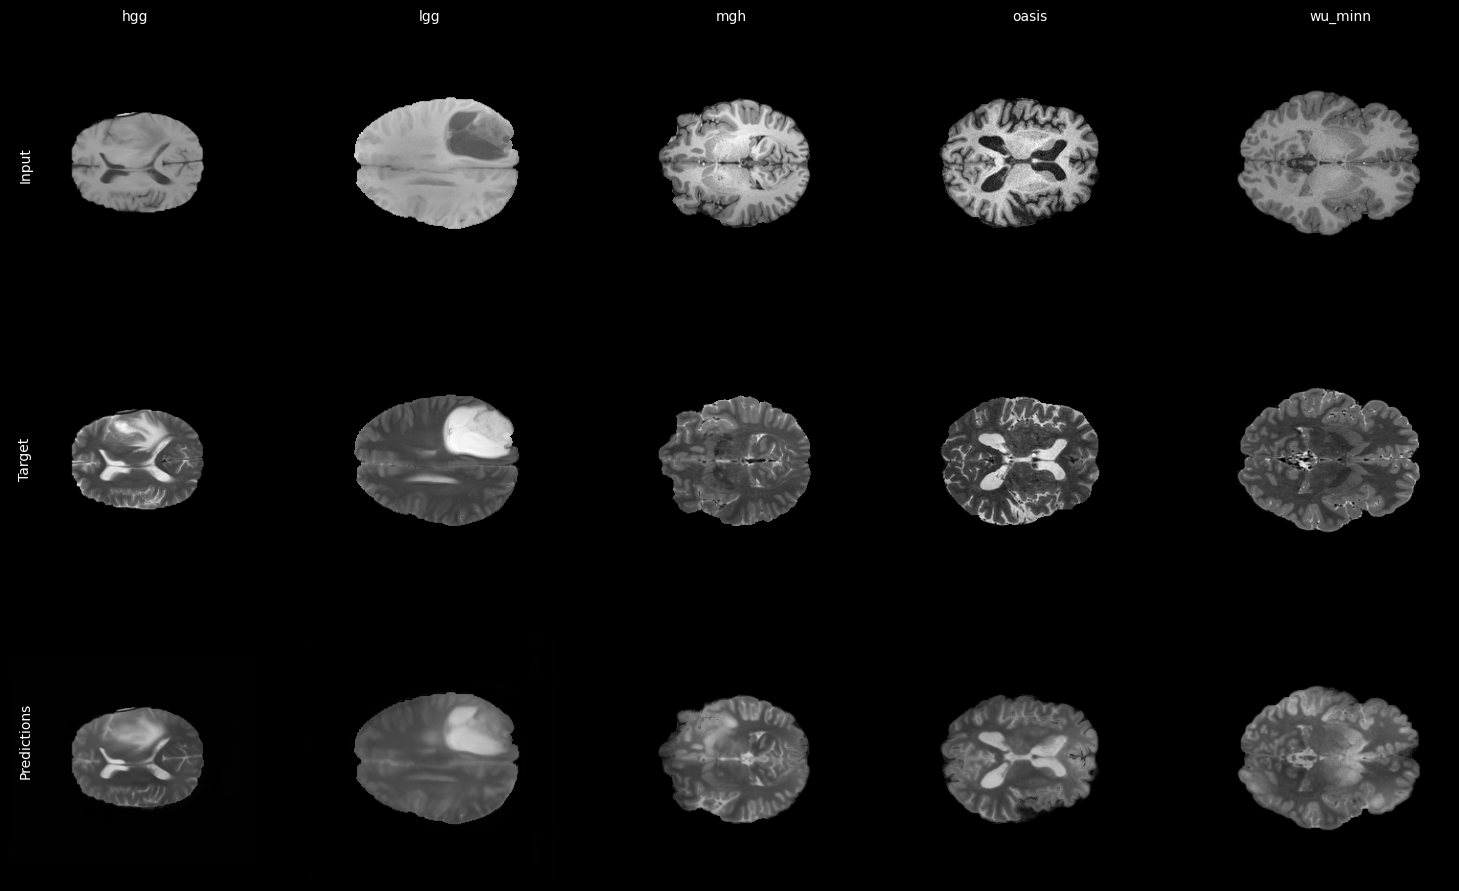

In [44]:
visualization.plot_pred([images, targets, hgg_predictions], datasets_labels, row_labels=["Input", "Target", "Predictions"])

In [49]:
eval_metrics_hgg = pd.DataFrame(get_evaluation_metrics(model_dir))
eval_metrics_hgg

hcp_mgh_masks  hcp_wu_minn     hgg_50        lgg  oasis_125
loss              0.091064     0.103170   0.090247   0.117875   0.131144
ssim              0.827783     0.808053   0.827351   0.773087   0.752778
zoomed_ssim       0.670537     0.665311   0.689400   0.653150   0.472955
pnsr             23.054031    21.440155  24.101993  23.601977  21.241199
mse               0.004960     0.007196   0.003923   0.004419   0.007533

## LGG

In [51]:
model_dir = "../trained_models/centralized-final/model-lgg-centralized-MSE_DSSIM-ep32-lr0.001-BN-2023-09-22-16h"

In [52]:
with open(f"{model_dir}/history.pkl", 'rb') as f:
    history = pickle.load(f)

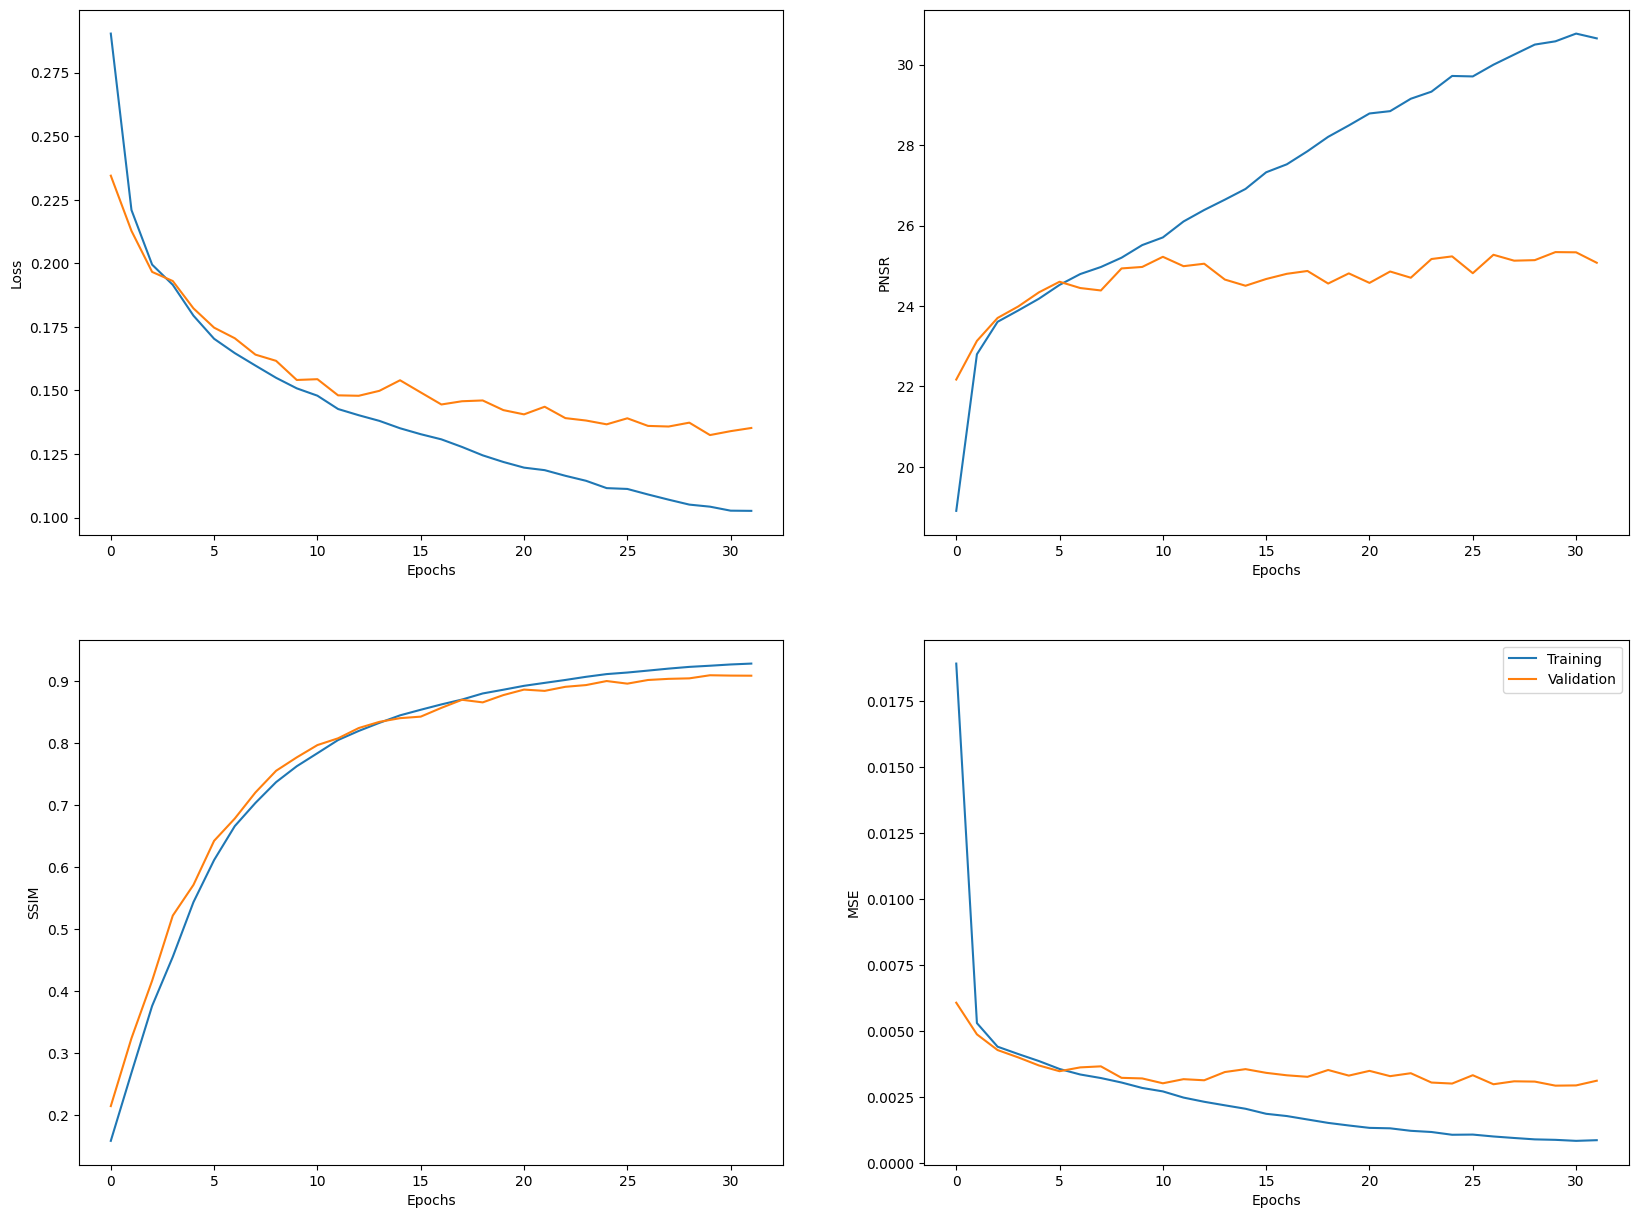

In [53]:
plot_history(history)

In [54]:
unet = models.UNet(normalization=NormalizationType.BN)
unet.load_state_dict(torch.load(f"{model_dir}/model.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [58]:
lgg_predictions = pred_on_different_ds(unet)

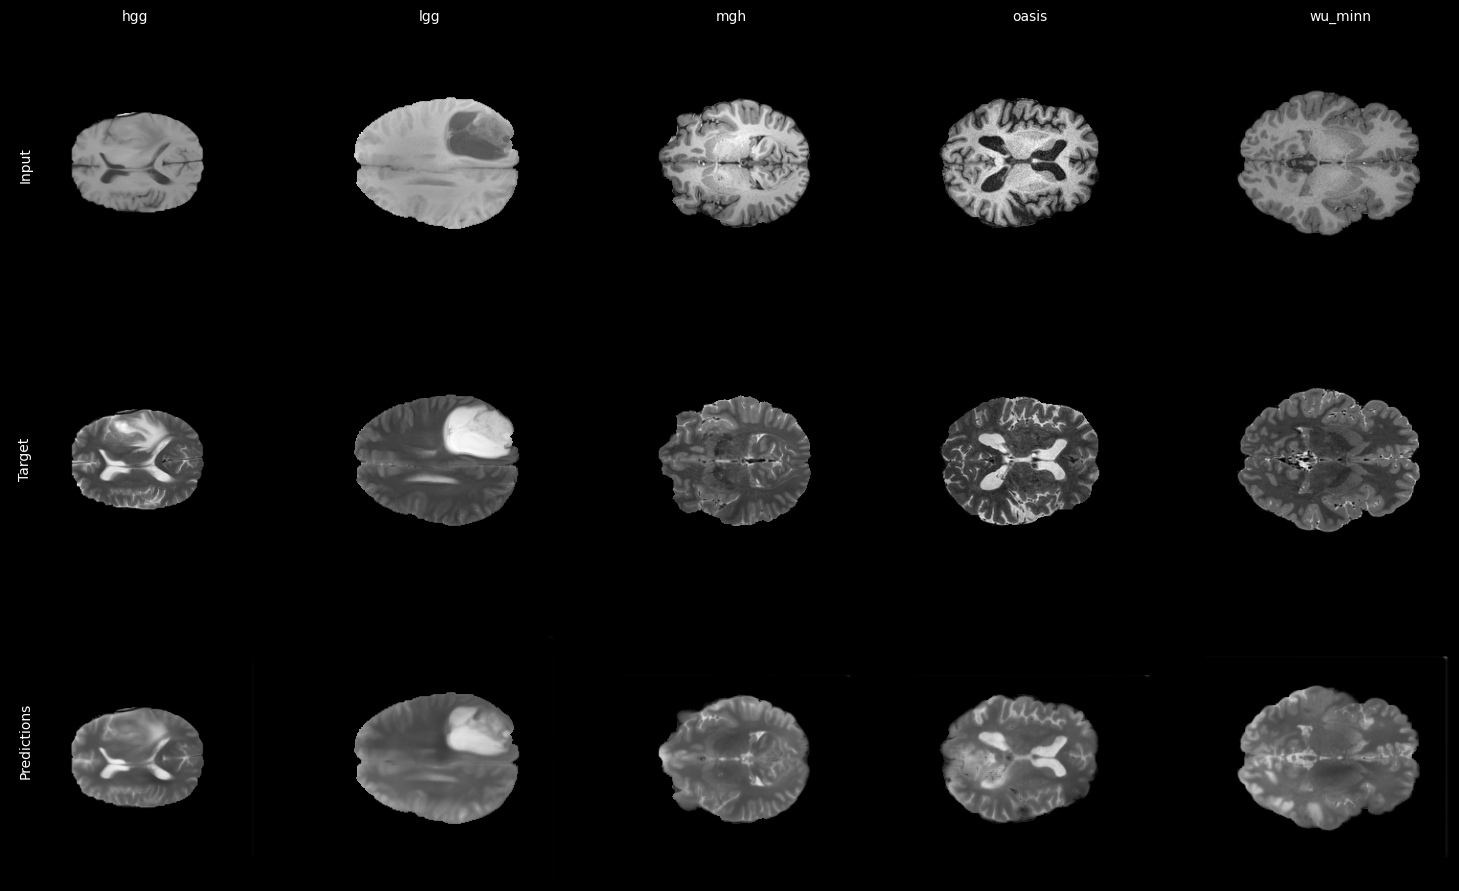

In [59]:
visualization.plot_pred([images, targets, lgg_predictions], datasets_labels, row_labels=["Input", "Target", "Predictions"])

In [60]:
eval_metrics_lgg = pd.DataFrame(get_evaluation_metrics(model_dir))
eval_metrics_lgg

hcp_mgh_masks  hcp_wu_minn     hgg_50        lgg  oasis_125
loss              0.079062     0.109924   0.058624   0.053679   0.121604
ssim              0.852694     0.797617   0.891299   0.899587   0.775563
zoomed_ssim       0.662030     0.645352   0.694134   0.712057   0.454985
pnsr             22.677133    20.603137  23.729710  24.670396  20.283570
mse               0.005410     0.008733   0.004273   0.003472   0.009386

## MGH

In [61]:
model_dir = "../trained_models/centralized-final/model-mgh-centralized-MSE_DSSIM-ep32-lr0.001-BN-2023-09-22-15h"

In [62]:
with open(f"{model_dir}/history.pkl", 'rb') as f:
    history = pickle.load(f)

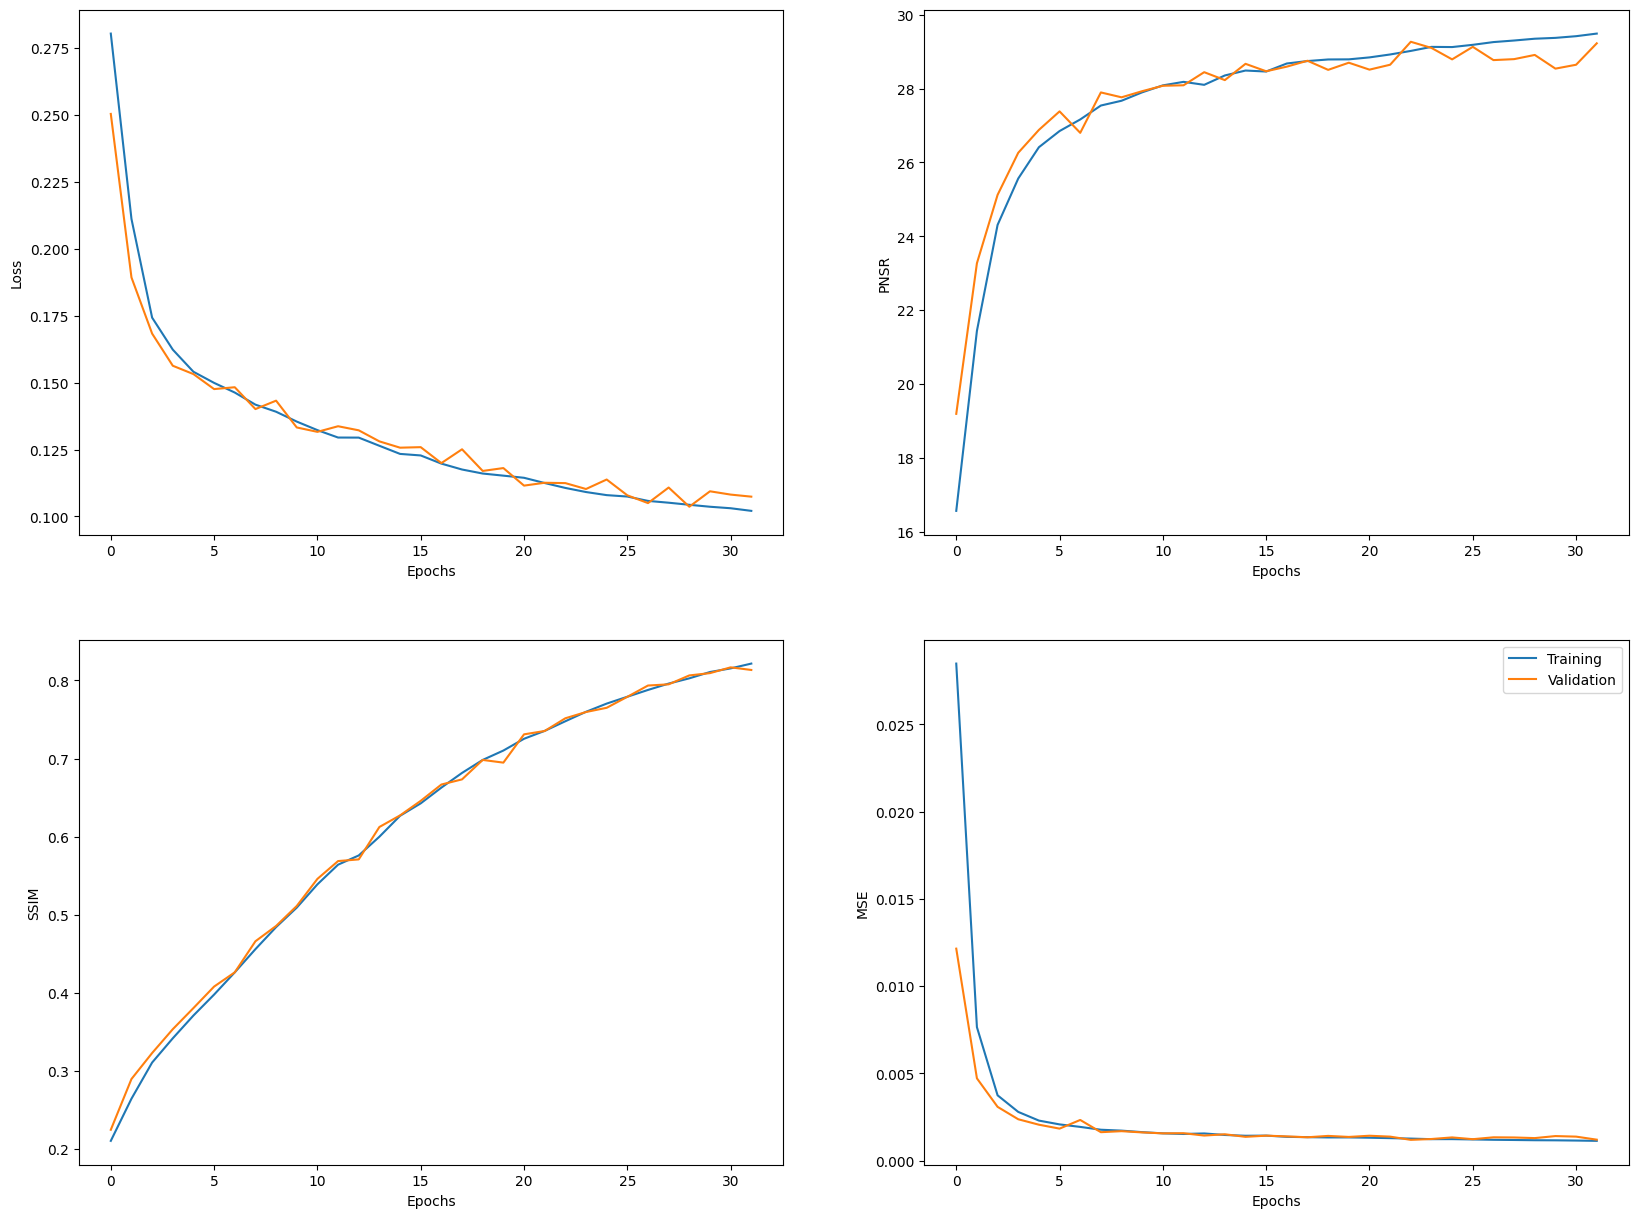

In [63]:
plot_history(history)

In [64]:
unet = models.UNet(normalization=NormalizationType.BN)
unet.load_state_dict(torch.load(f"{model_dir}/model.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [67]:
mgh_predictions = pred_on_different_ds(unet)

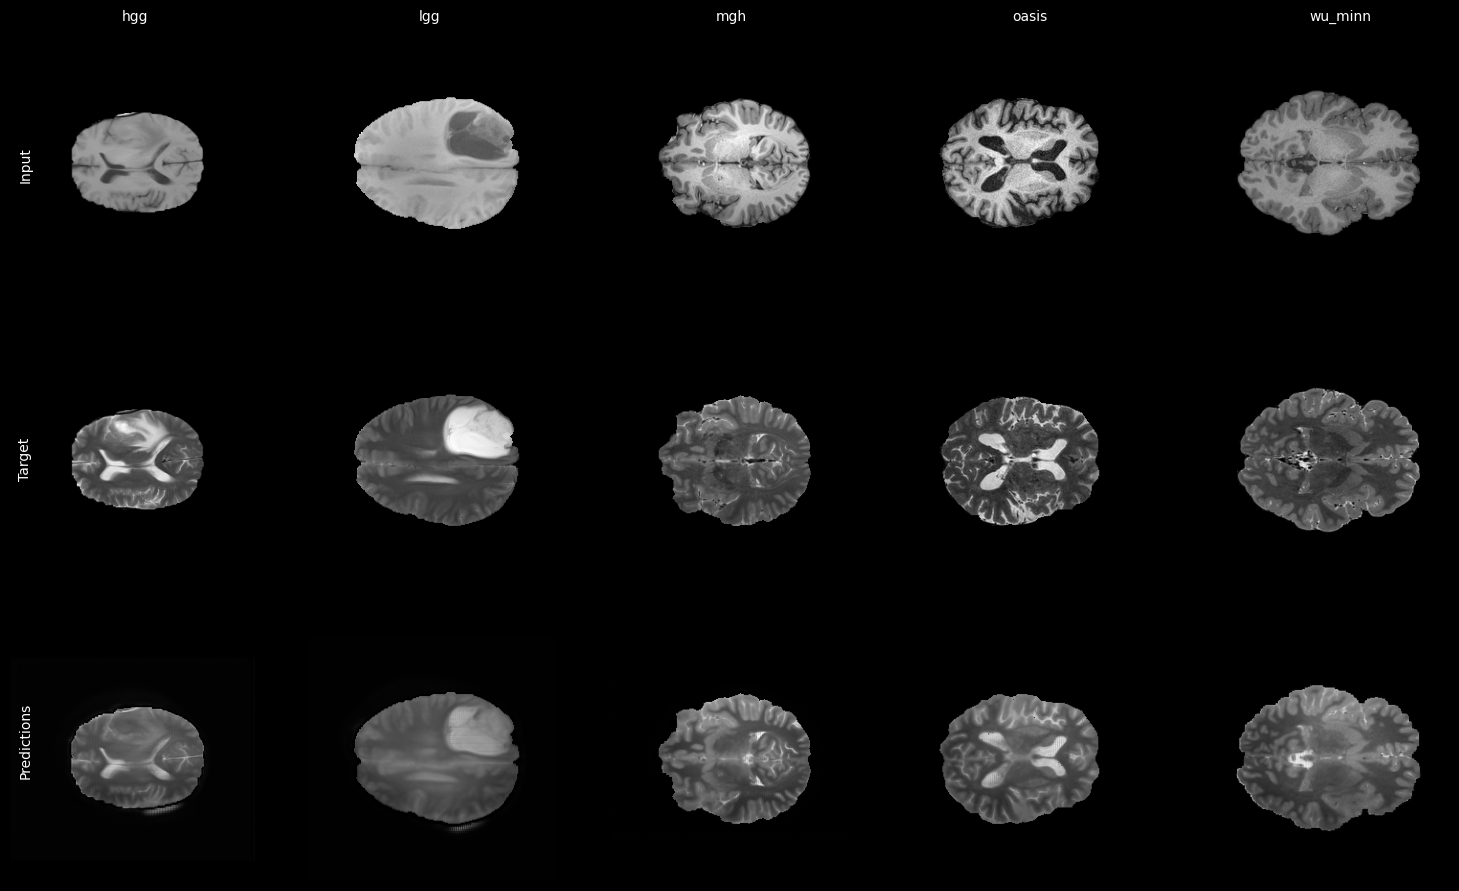

In [68]:
visualization.plot_pred([images, targets, mgh_predictions], datasets_labels, row_labels=["Input", "Target", "Predictions"])

In [69]:
eval_metrics_mgh = pd.DataFrame(get_evaluation_metrics(model_dir))
eval_metrics_mgh

hcp_mgh_masks  hcp_wu_minn     hgg_50        lgg  oasis_125
loss              0.094837     0.094083   0.192543   0.255629   0.167744
ssim              0.812802     0.822105   0.627475   0.502938   0.677343
zoomed_ssim       0.789391     0.722000   0.589375   0.553792   0.487995
pnsr             29.065611    22.902451  22.039347  21.567746  21.937444
mse               0.001246     0.005135   0.006280   0.007098   0.006416

## WU MINN

In [71]:
model_dir = "../trained_models/centralized-final/model-wu-minn-centralized-MSE_DSSIM-ep32-lr0.001-BN-2023-09-22-15h"

In [72]:
with open(f"{model_dir}/history.pkl", 'rb') as f:
    history = pickle.load(f)

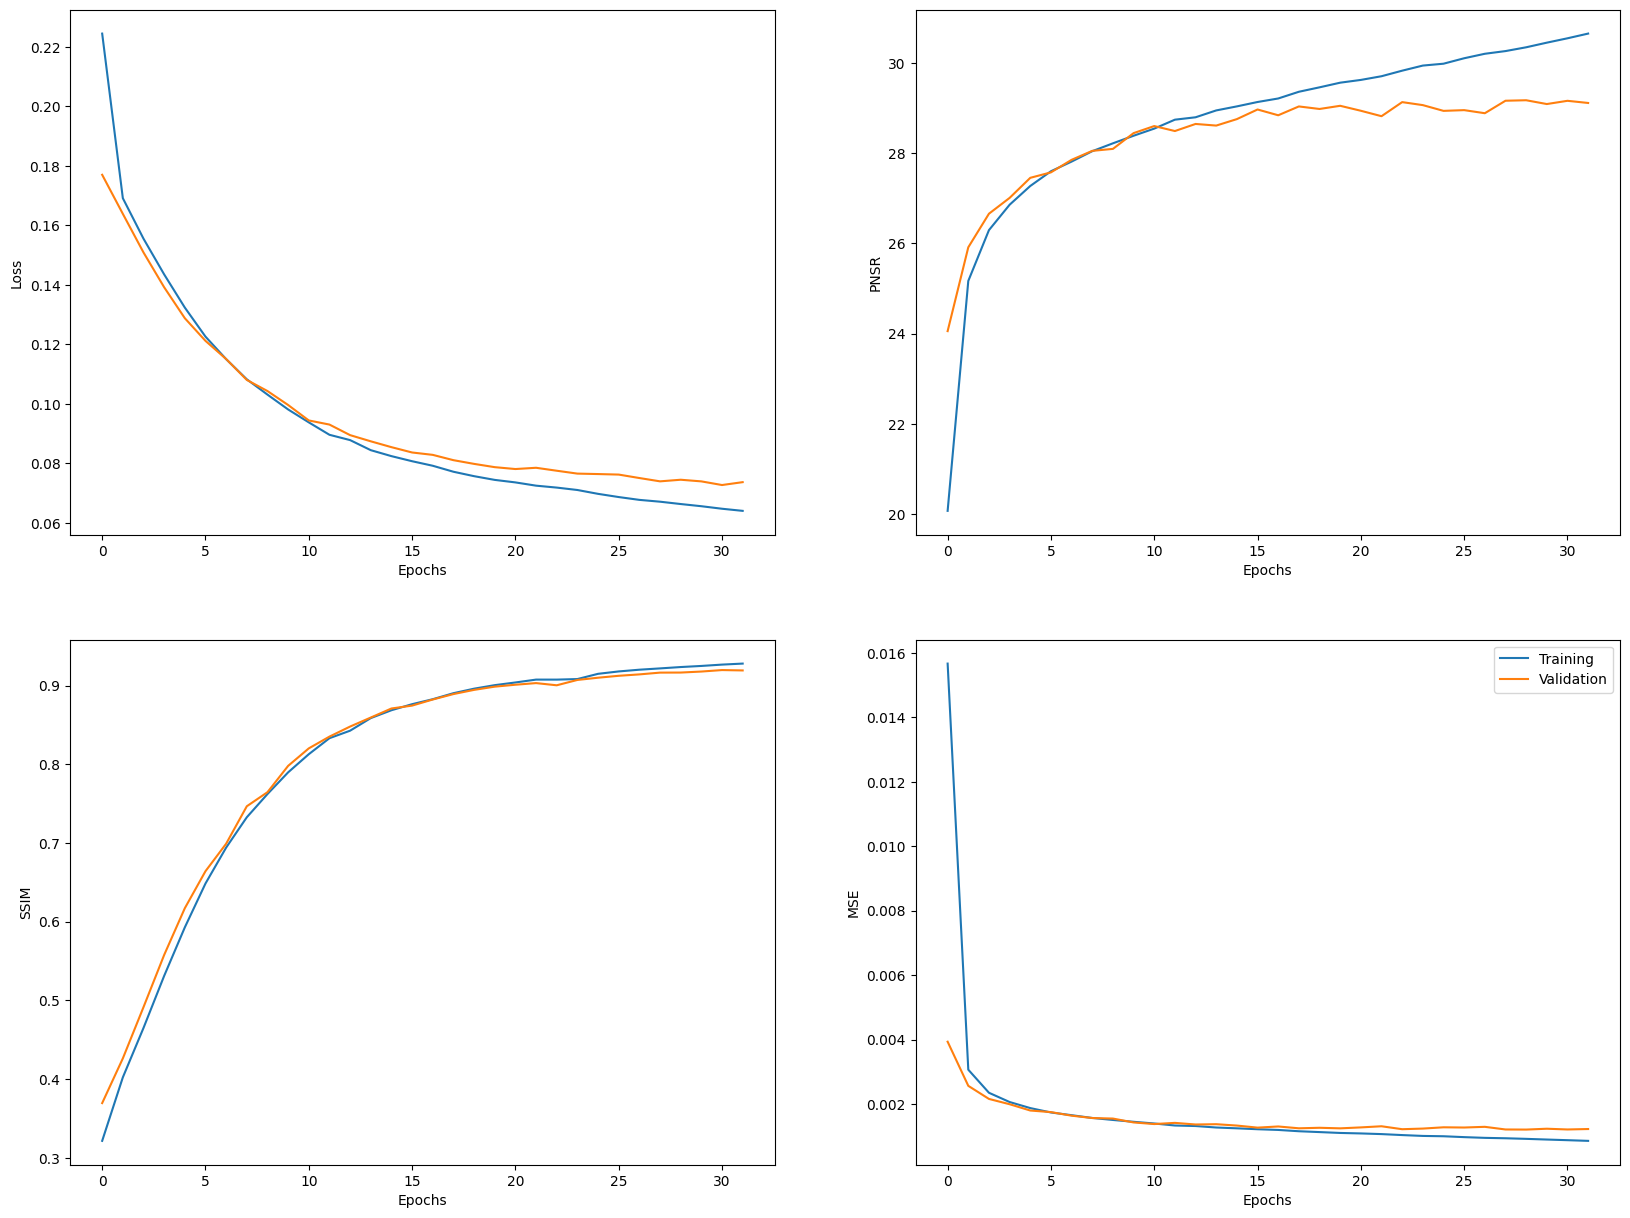

In [73]:
plot_history(history)

In [74]:
unet = models.UNet(normalization=NormalizationType.BN)
unet.load_state_dict(torch.load(f"{model_dir}/model.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [76]:
wu_minn_predictions = pred_on_different_ds(unet)

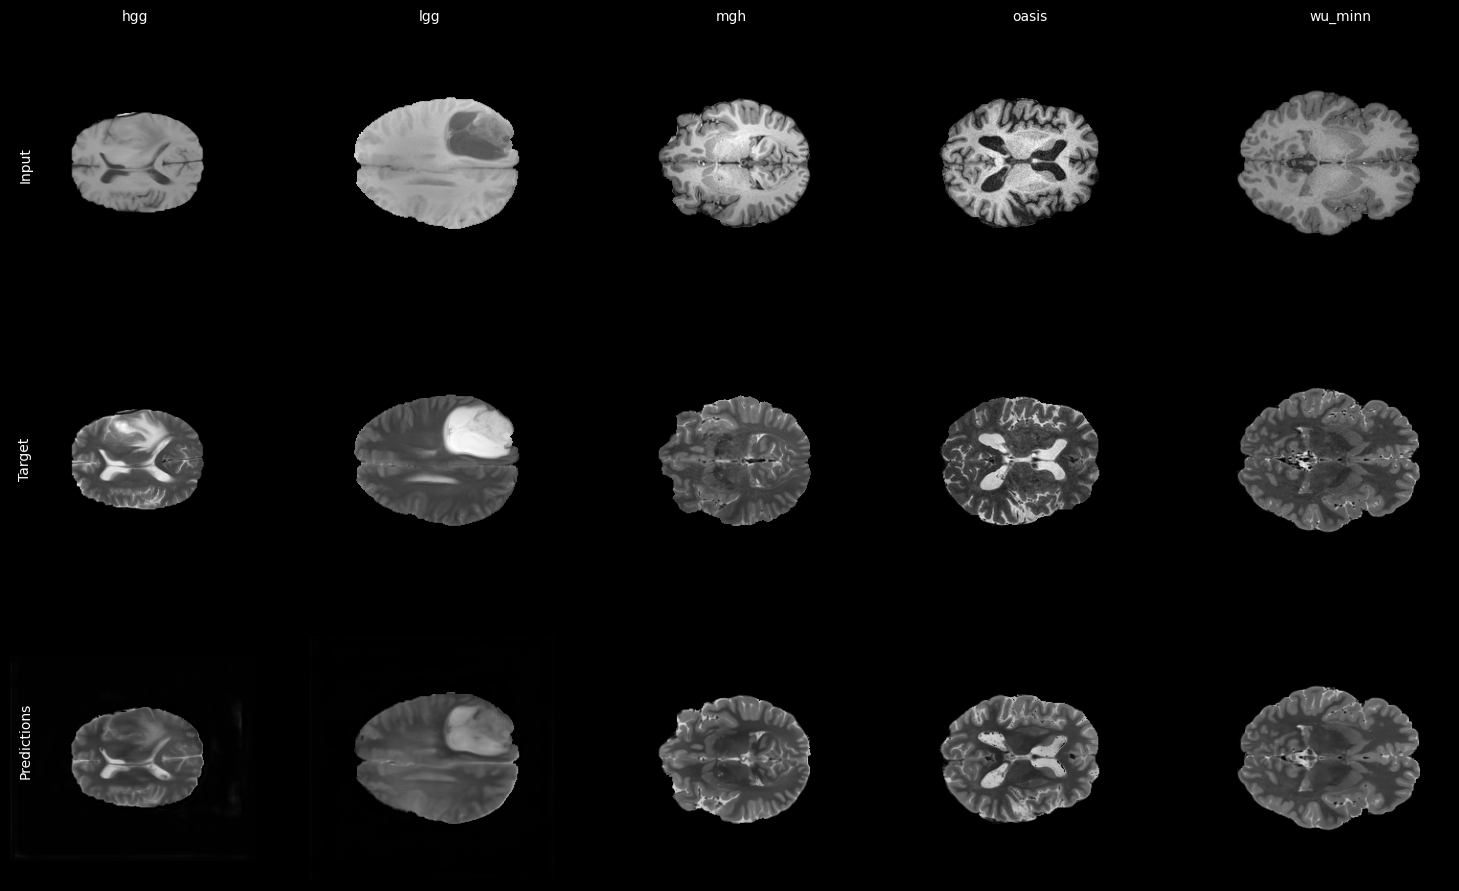

In [77]:
visualization.plot_pred([images, targets, wu_minn_predictions], datasets_labels, row_labels=["Input", "Target", "Predictions"])

In [78]:
eval_metrics_wu_minn = pd.DataFrame(get_evaluation_metrics(model_dir))
eval_metrics_wu_minn

hcp_mgh_masks  hcp_wu_minn     hgg_50        lgg  oasis_125
loss              0.089316     0.044496   0.127602   0.190415   0.131346
ssim              0.830865     0.913645   0.756843   0.635083   0.751116
zoomed_ssim       0.703882     0.848898   0.619587   0.557826   0.494628
pnsr             23.239920    28.820882  22.256788  21.090306  21.617537
mse               0.004753     0.001318   0.006023   0.007956   0.006904

## Oasis

In [79]:
model_dir = "../trained_models/centralized-final/model-oasis-centralized-MSE_DSSIM-ep32-lr0.001-BN-2023-09-22-16h"

In [80]:
with open(f"{model_dir}/history.pkl", 'rb') as f:
    history = pickle.load(f)

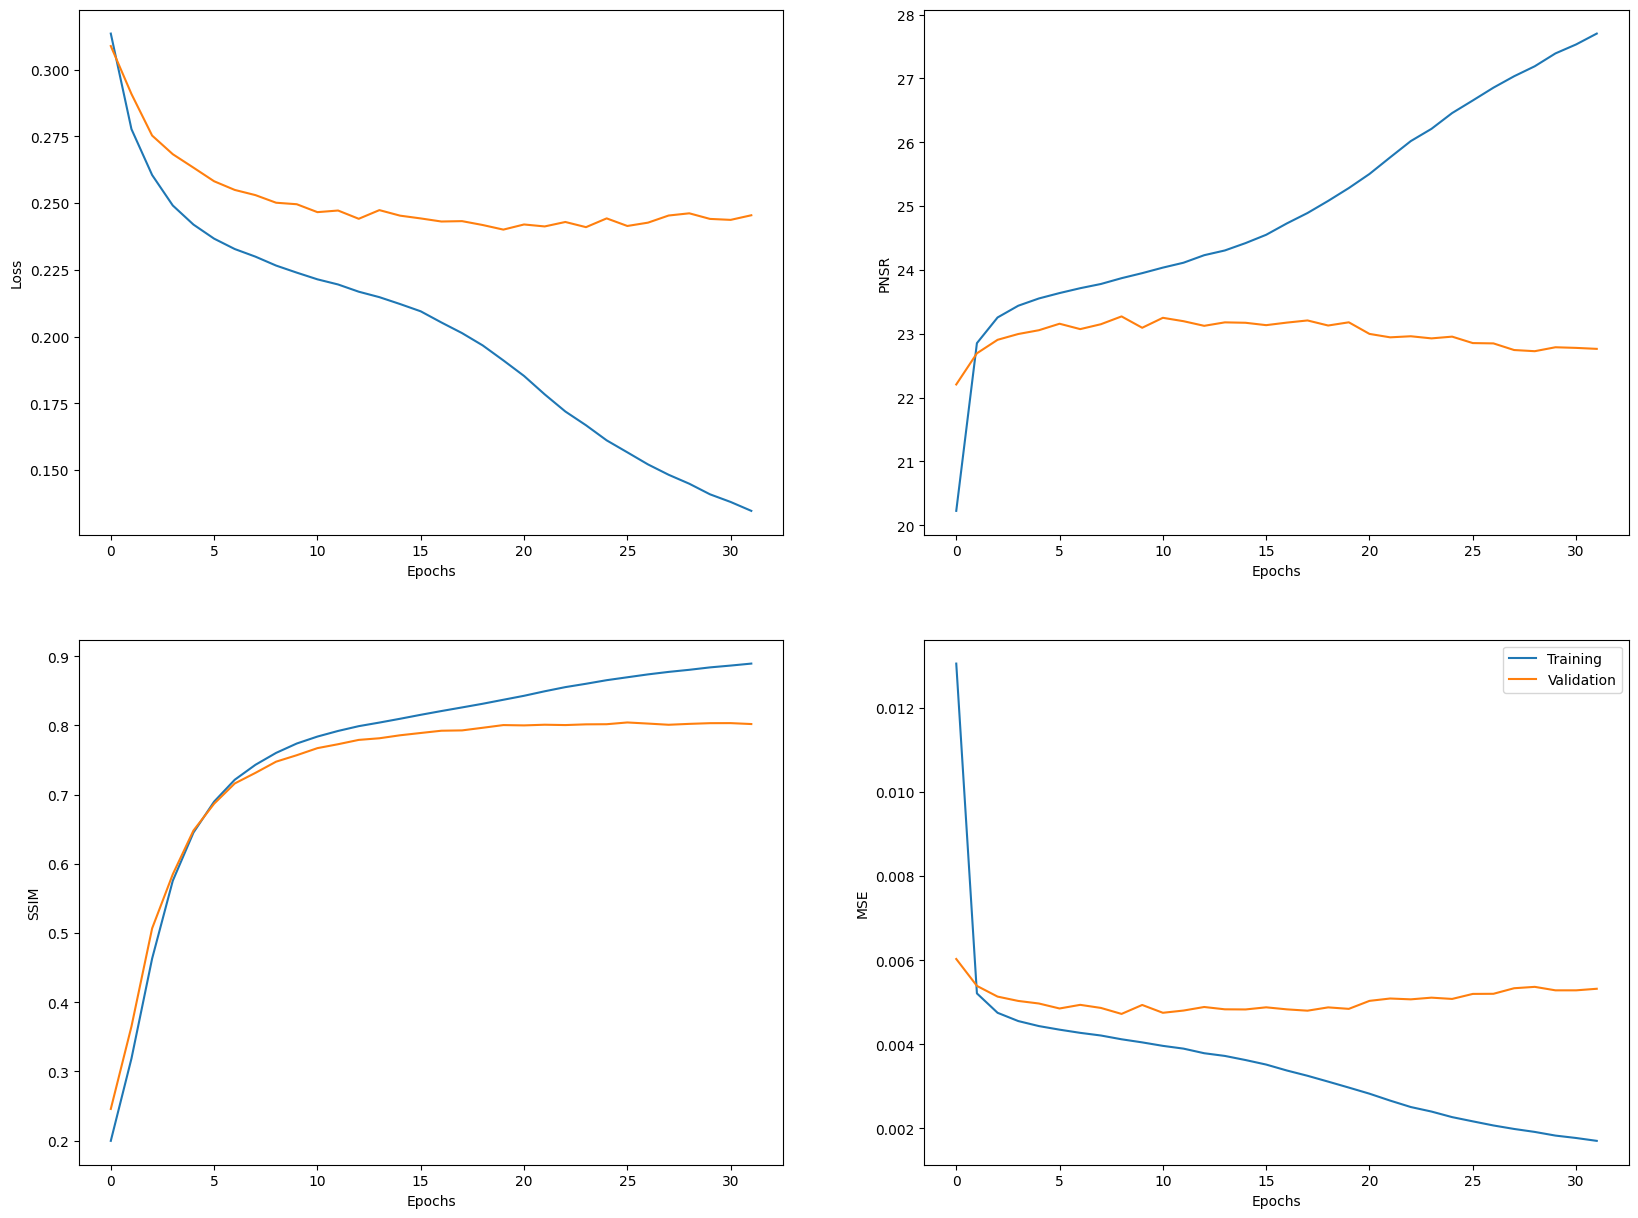

In [81]:
plot_history(history)

In [82]:
unet = models.UNet(normalization=NormalizationType.BN)
unet.load_state_dict(torch.load(f"{model_dir}/model.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [85]:
oasis_predictions = pred_on_different_ds(unet)

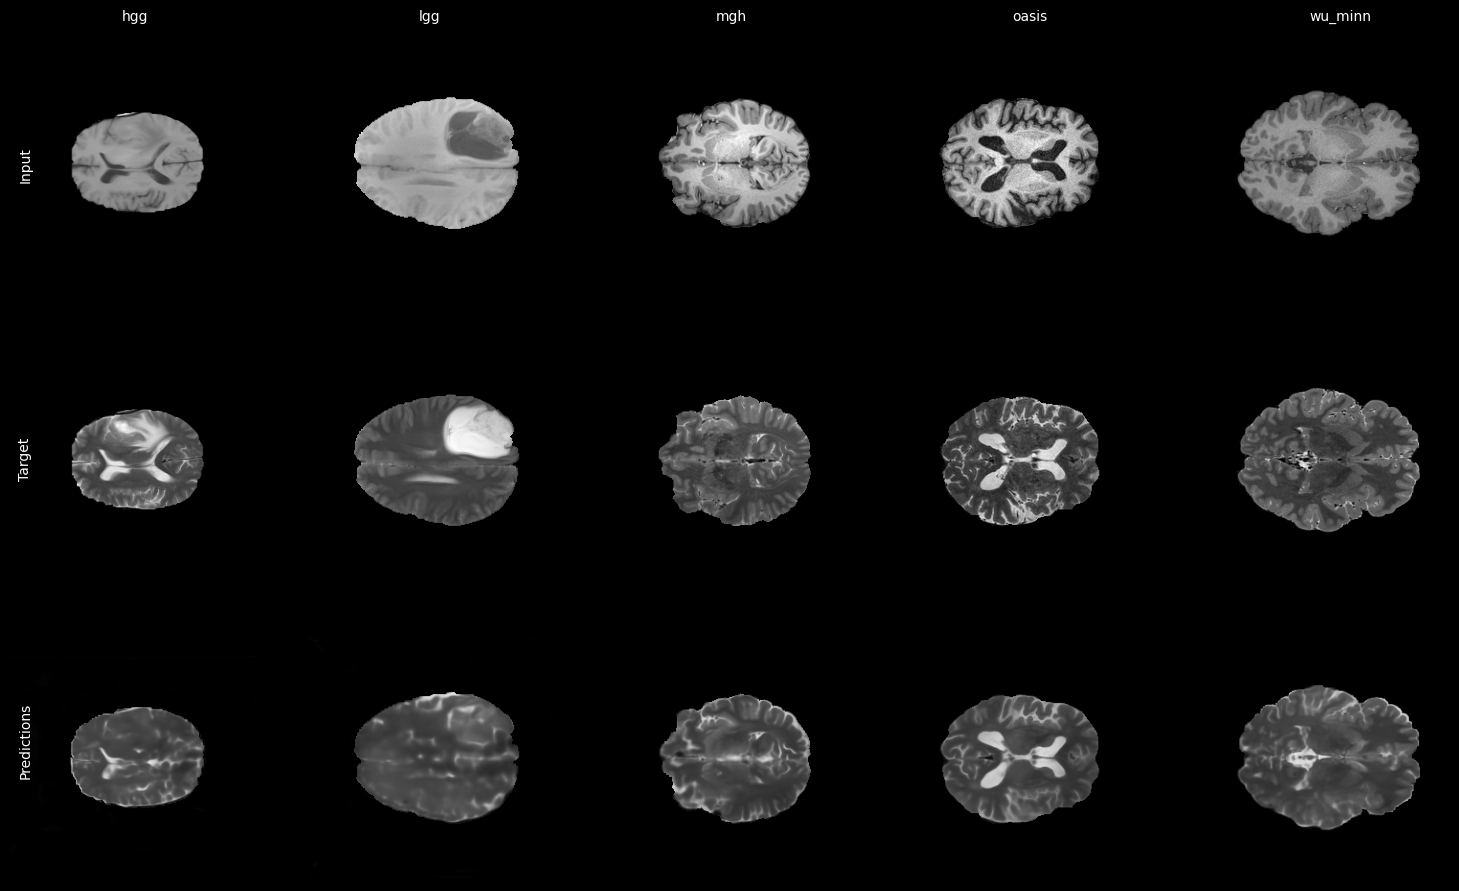

In [86]:
visualization.plot_pred([images, targets, oasis_predictions], datasets_labels, row_labels=["Input", "Target", "Predictions"])

In [87]:
eval_metrics_oasis = pd.DataFrame(get_evaluation_metrics(model_dir))
eval_metrics_oasis

hcp_mgh_masks  hcp_wu_minn     hgg_50        lgg  oasis_125
loss              0.097364     0.117507   0.106929   0.118035   0.094691
ssim              0.815963     0.776708   0.803223   0.782050   0.819489
zoomed_ssim       0.563556     0.595811   0.471556   0.462659   0.554254
pnsr             22.725004    22.325778  20.713314  20.527120  23.553682
mse               0.005347     0.005861   0.008541   0.009060   0.004436

In [31]:
none_dssim_model_dir = "../trained_models/server/model-centralized-ep32-lr0.001-BN-2023-08-28-15h"
os.listdir(none_dssim_model_dir)

['history.pkl', 'model.pth', 'predictions']

In [32]:
with open(f"{none_dssim_model_dir}/history.pkl", 'rb') as f:
    history = pickle.load(f)

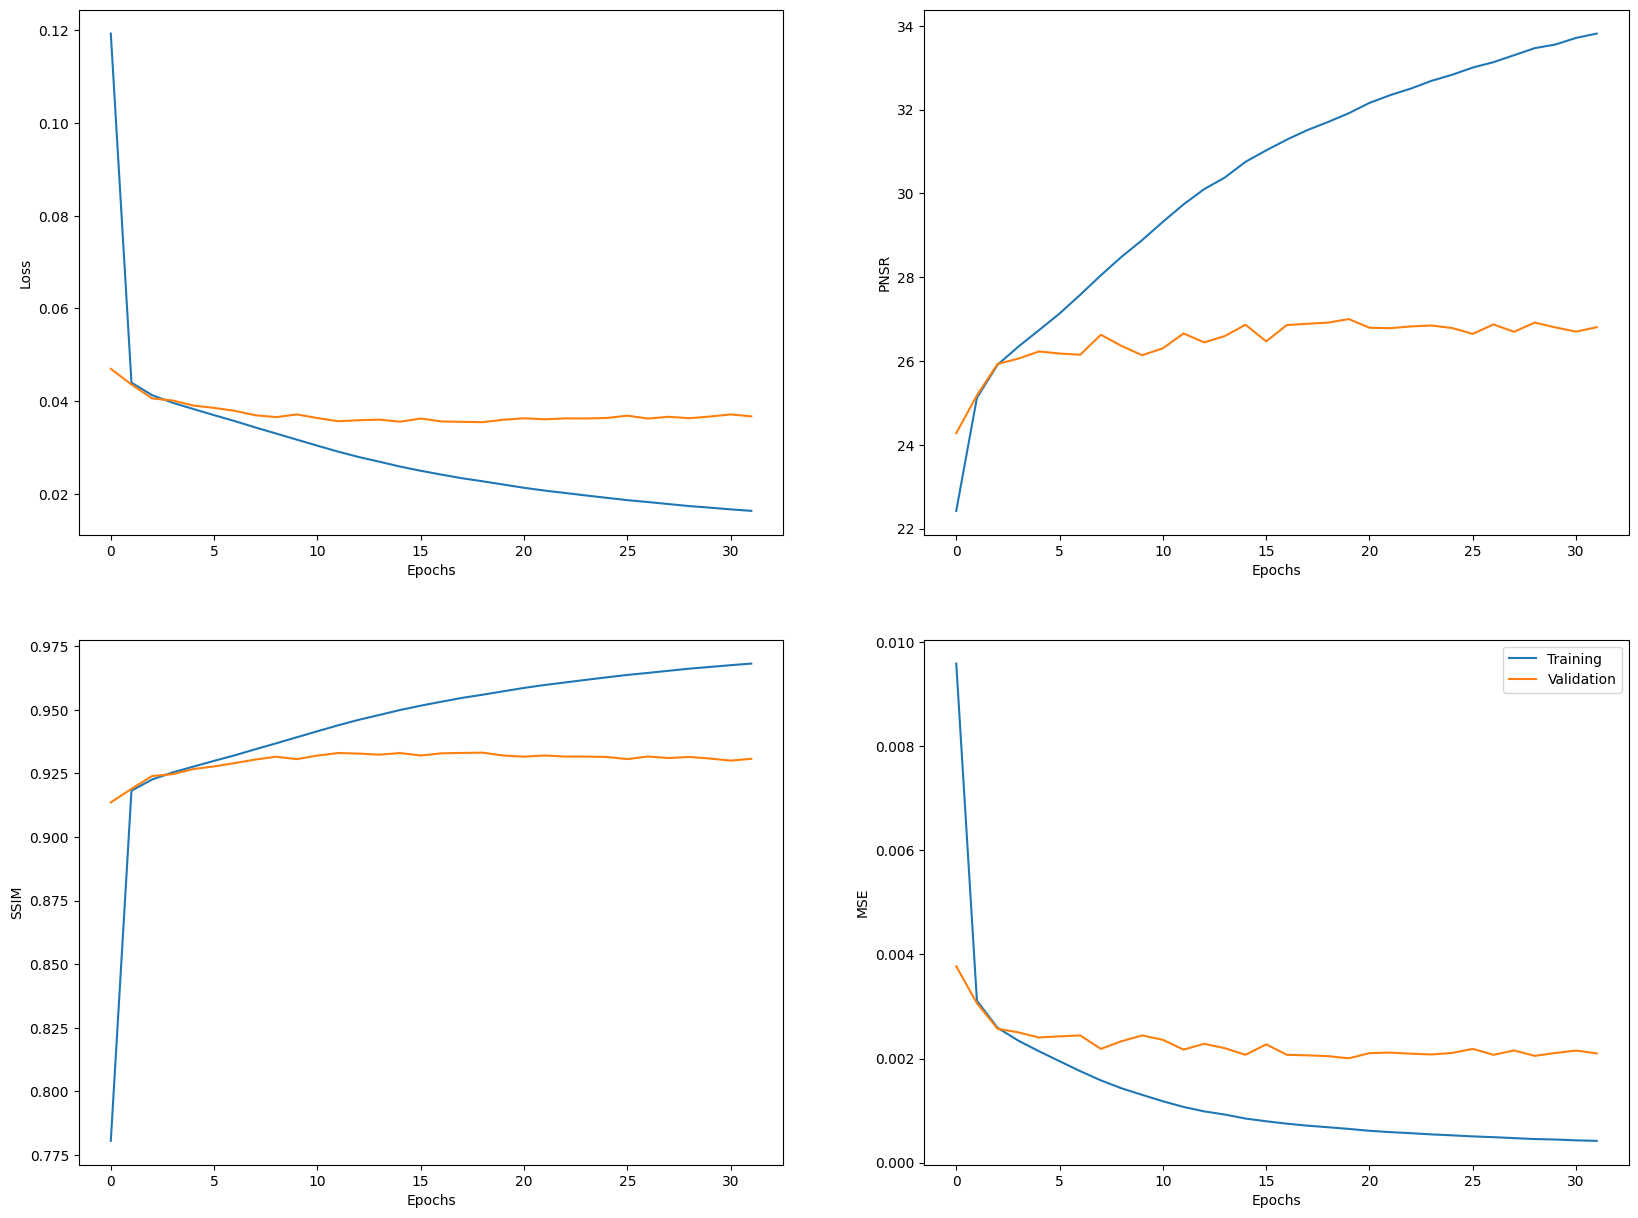

In [33]:
plot_history(history)

In [34]:
unet = models.UNet(normalization=NormalizationType.BN)
unet.load_state_dict(torch.load(f"{none_dssim_model_dir}/model.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [35]:
predictions_fl_bn = unet(images)

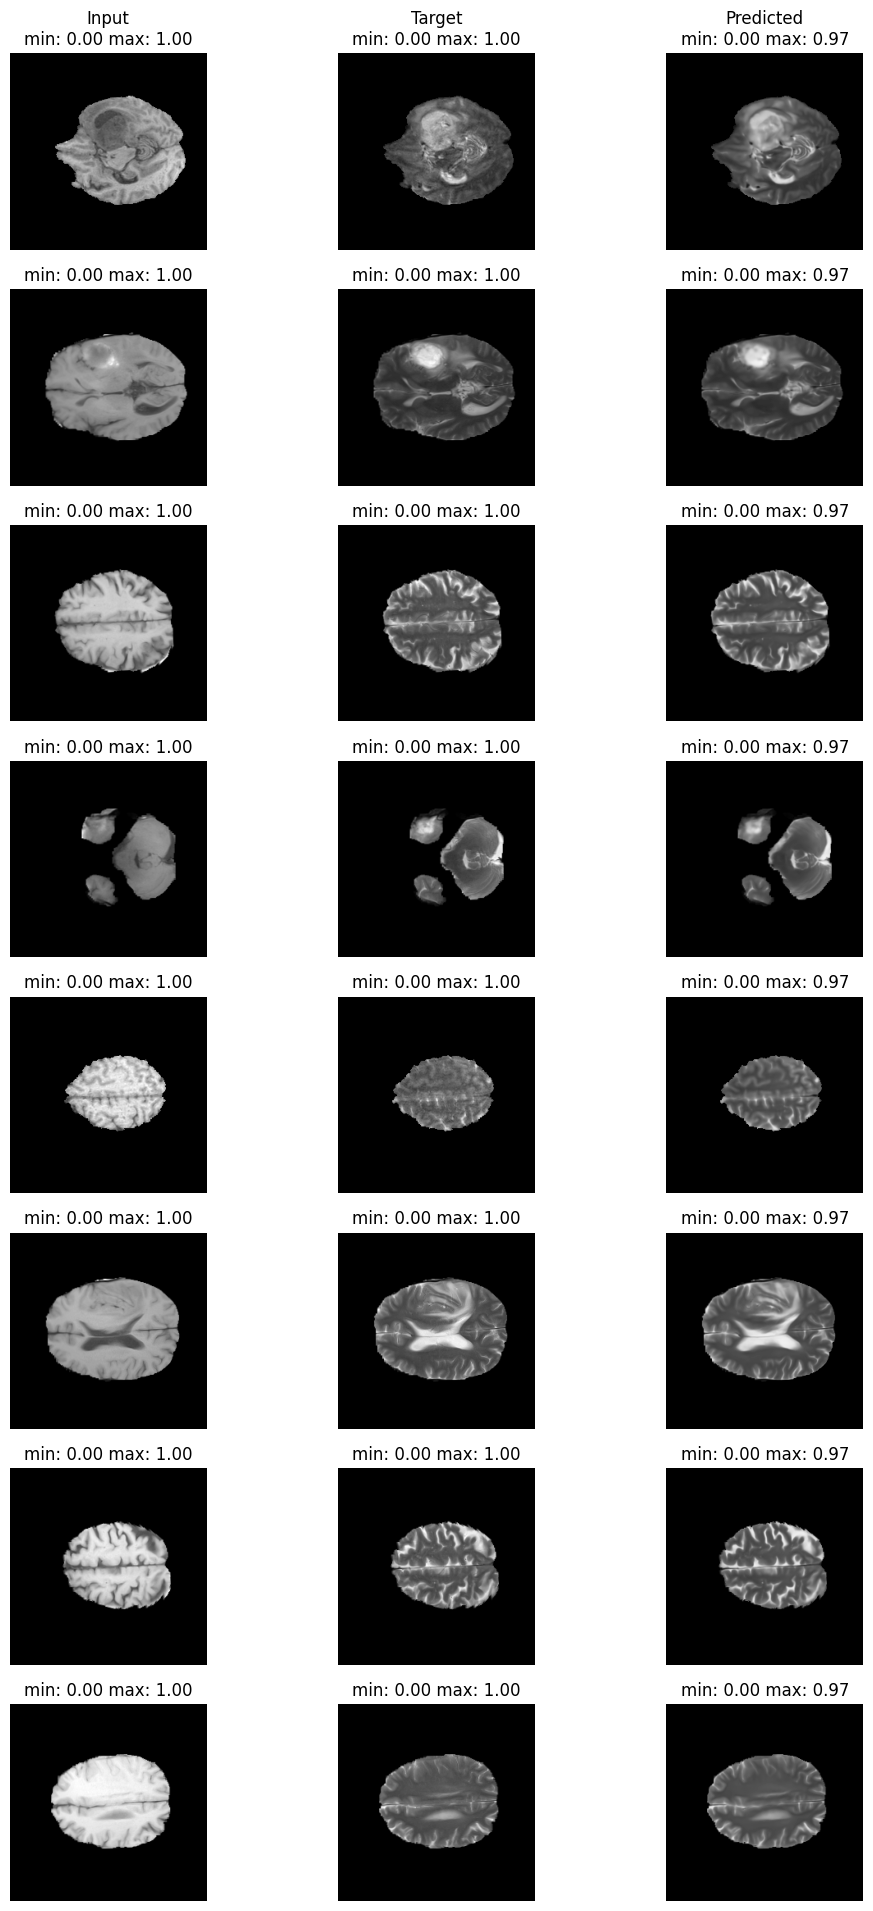

In [36]:
visualization.plot_batch([images, labels, predictions_fl_bn.detach()], ["Input", "Target", "Predicted"])

# Zoomed SSIM loss

In [11]:
none_dssim_model_dir = "../trained_models/server/model-centralized--MSE_ZOOMED_DSSIM-ep32-lr0.001-BN-2023-09-08-13h"
os.listdir(none_dssim_model_dir)

['history.pkl', 'model.pth', 'predictions']

In [12]:
with open(f"{none_dssim_model_dir}/history.pkl", 'rb') as f:
    history = pickle.load(f)

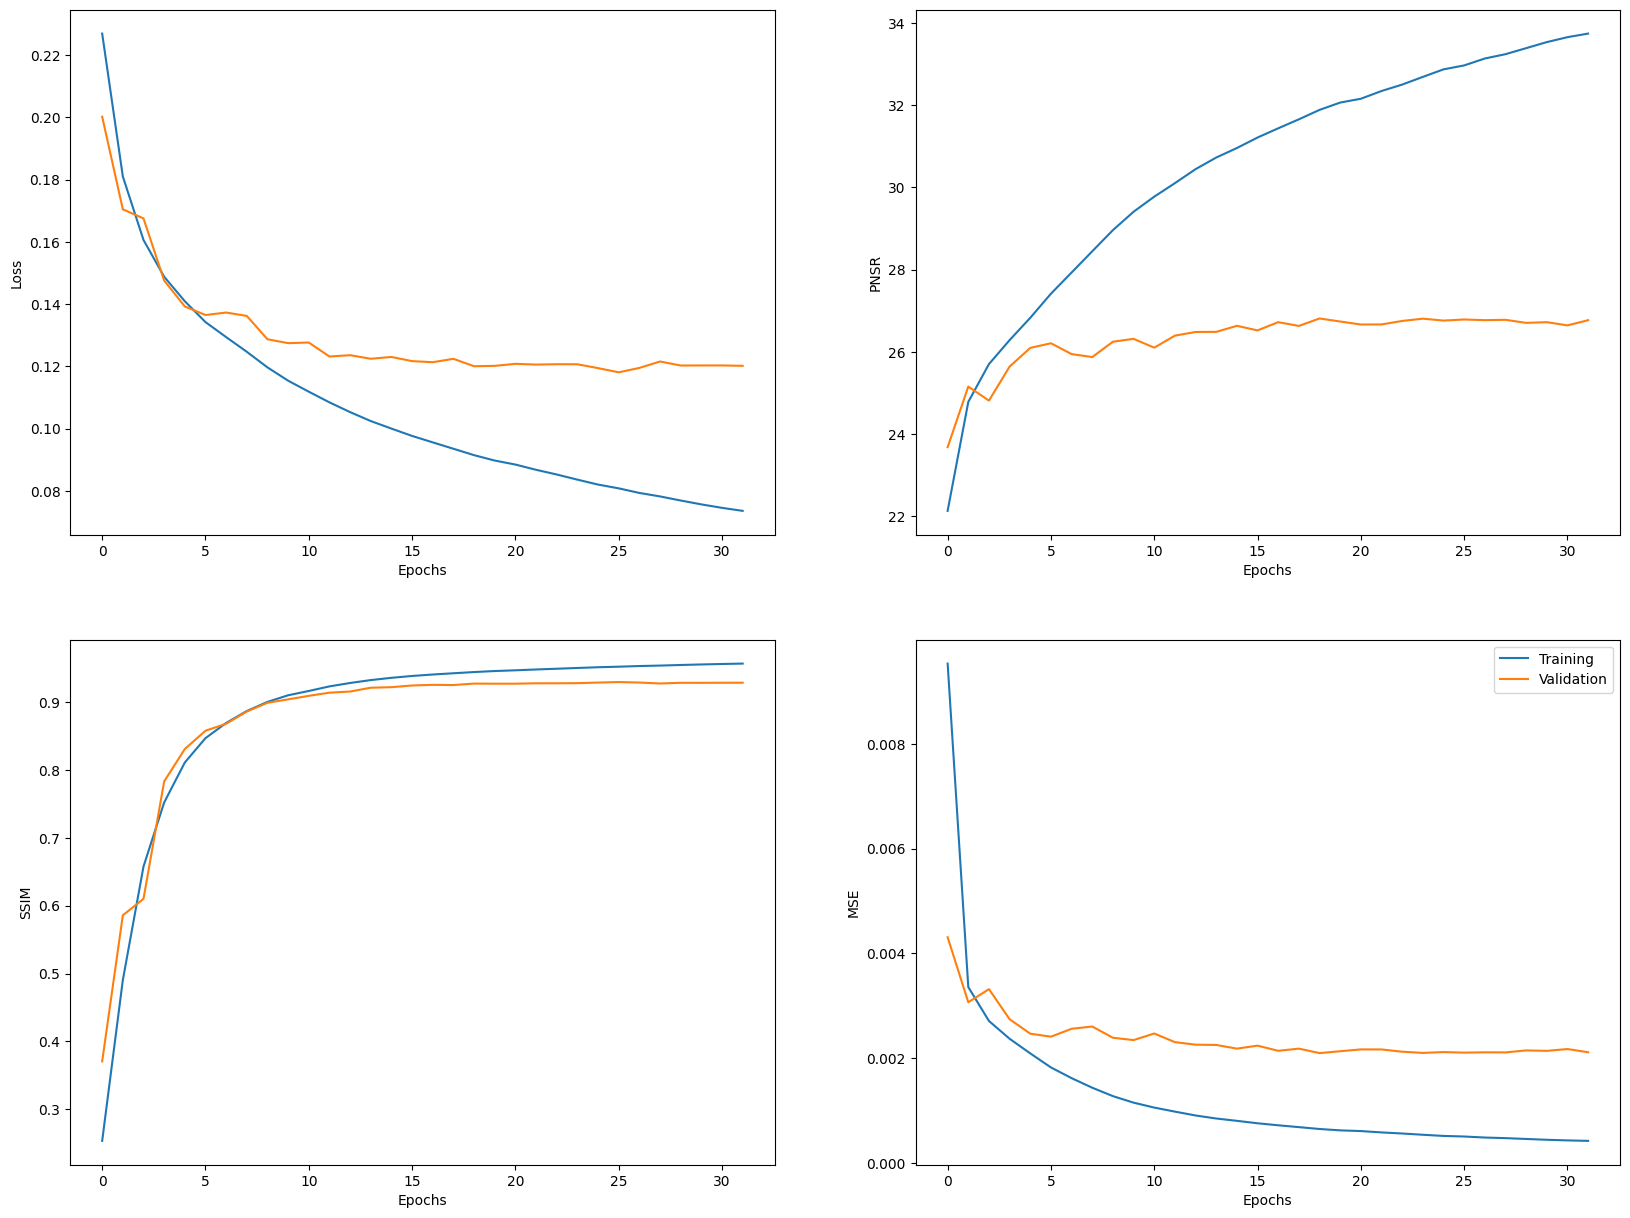

In [13]:
plot_history(history)

In [14]:
unet = models.UNet(normalization=NormalizationType.BN)
unet.load_state_dict(torch.load(f"{none_dssim_model_dir}/model.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [15]:
predictions_fl_zoomed = unet(images)

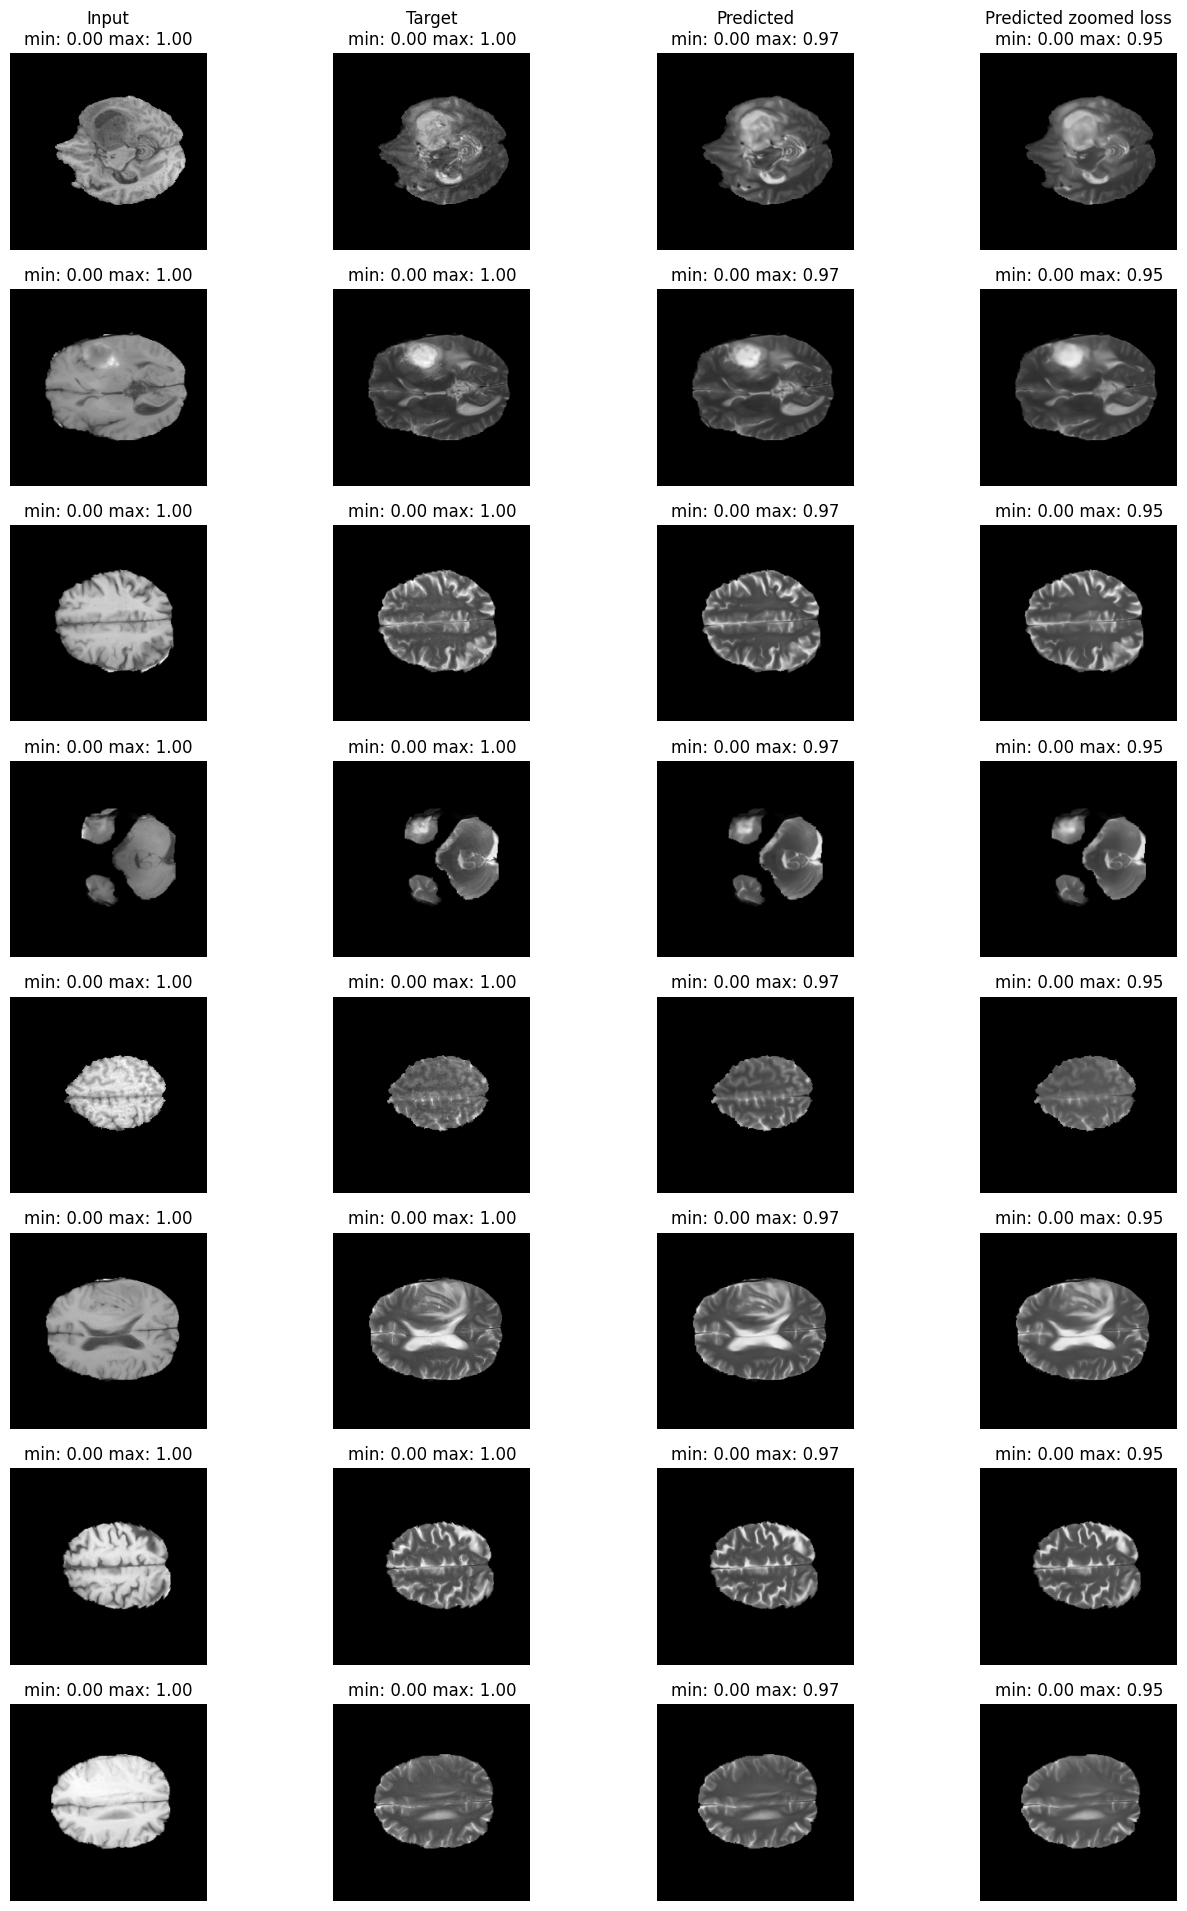

In [16]:
visualization.plot_batch([images, labels, predictions_fl_gn.detach(), predictions_fl_zoomed.detach()], ["Input", "Target", "Predicted", "Predicted zoomed loss"])

# GroupNorm Dssim_MSE

In [37]:
gn_dssim_model_dir = "../trained_models/server/model-centralized-ep32-lr0.001-GN-2023-09-01-11h"
os.listdir(gn_dssim_model_dir)

['history.pkl', 'model.pth', 'predictions']

In [38]:
with open(f"{gn_dssim_model_dir}/history.pkl", 'rb') as f:
    history = pickle.load(f)

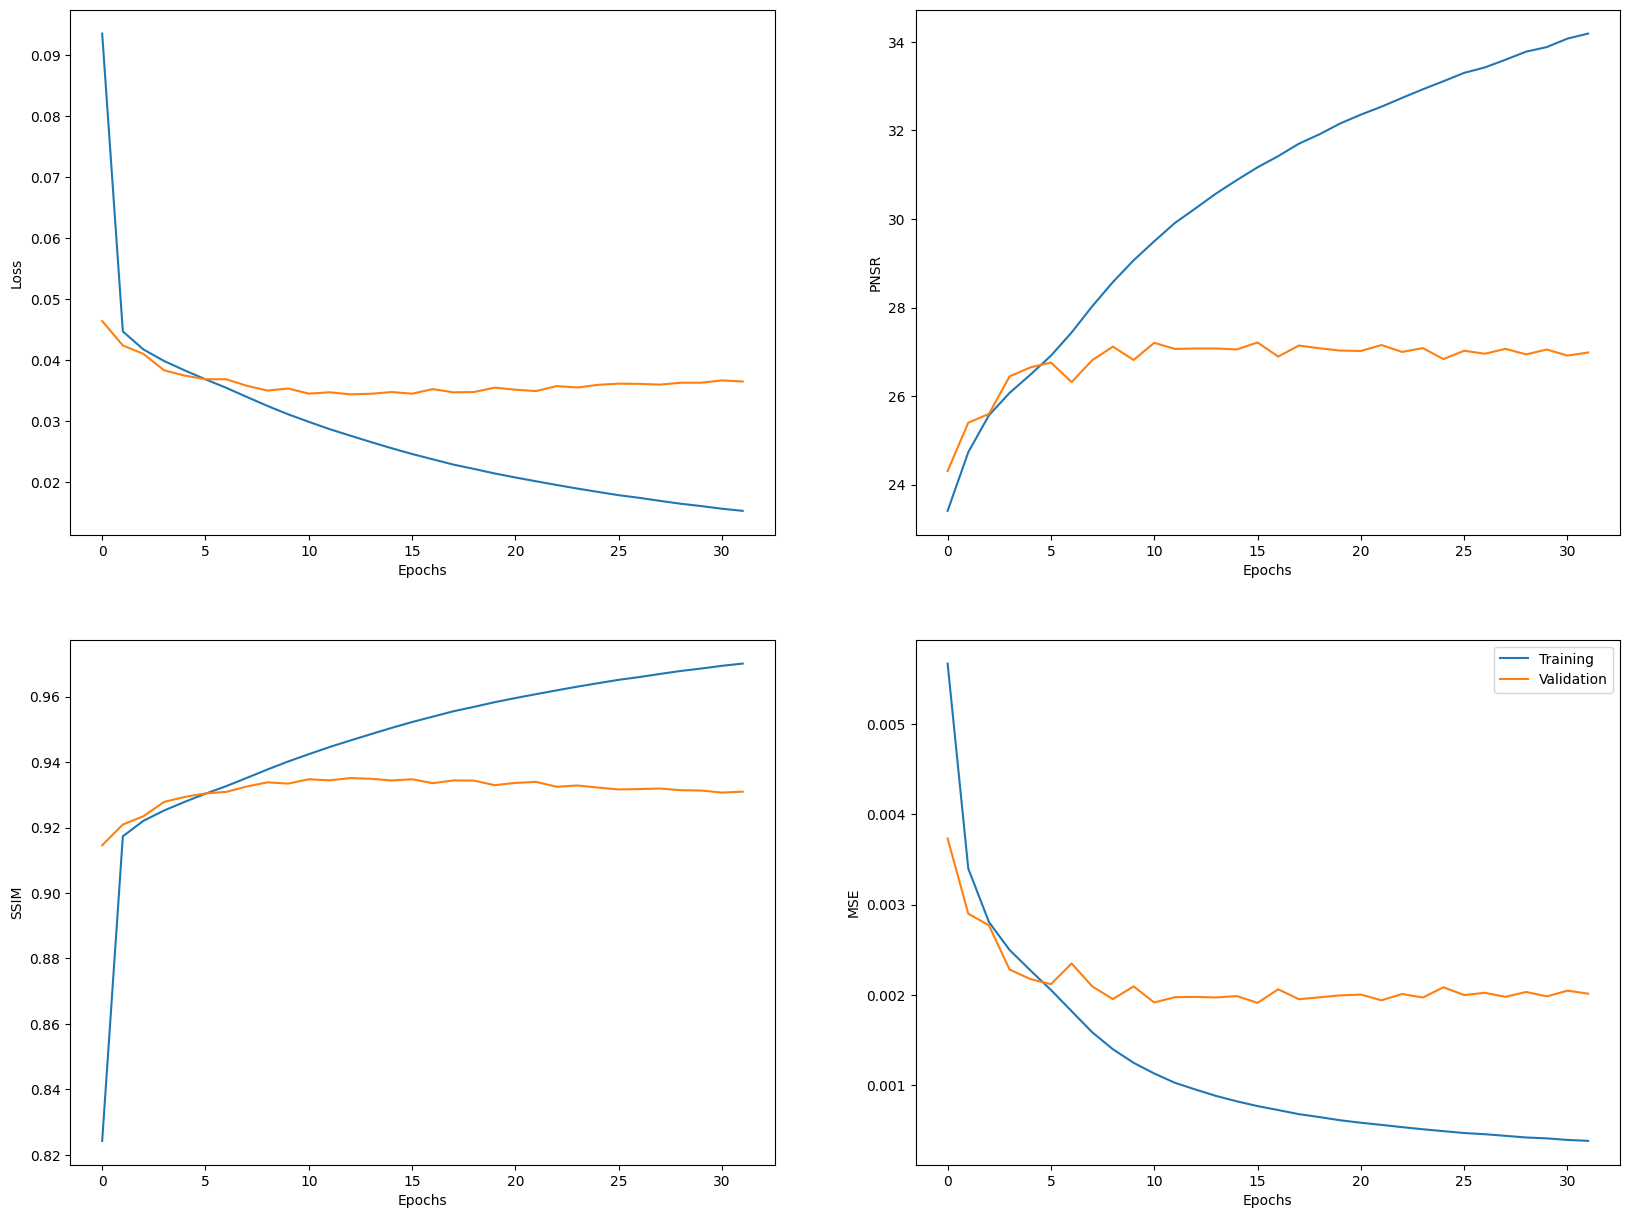

In [39]:
plot_history(history)

In [40]:
unet = models.UNet(normalization=NormalizationType.GN)
unet.load_state_dict(torch.load(f"{gn_dssim_model_dir}/model.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [41]:
predictions_fl_gn = unet(images)

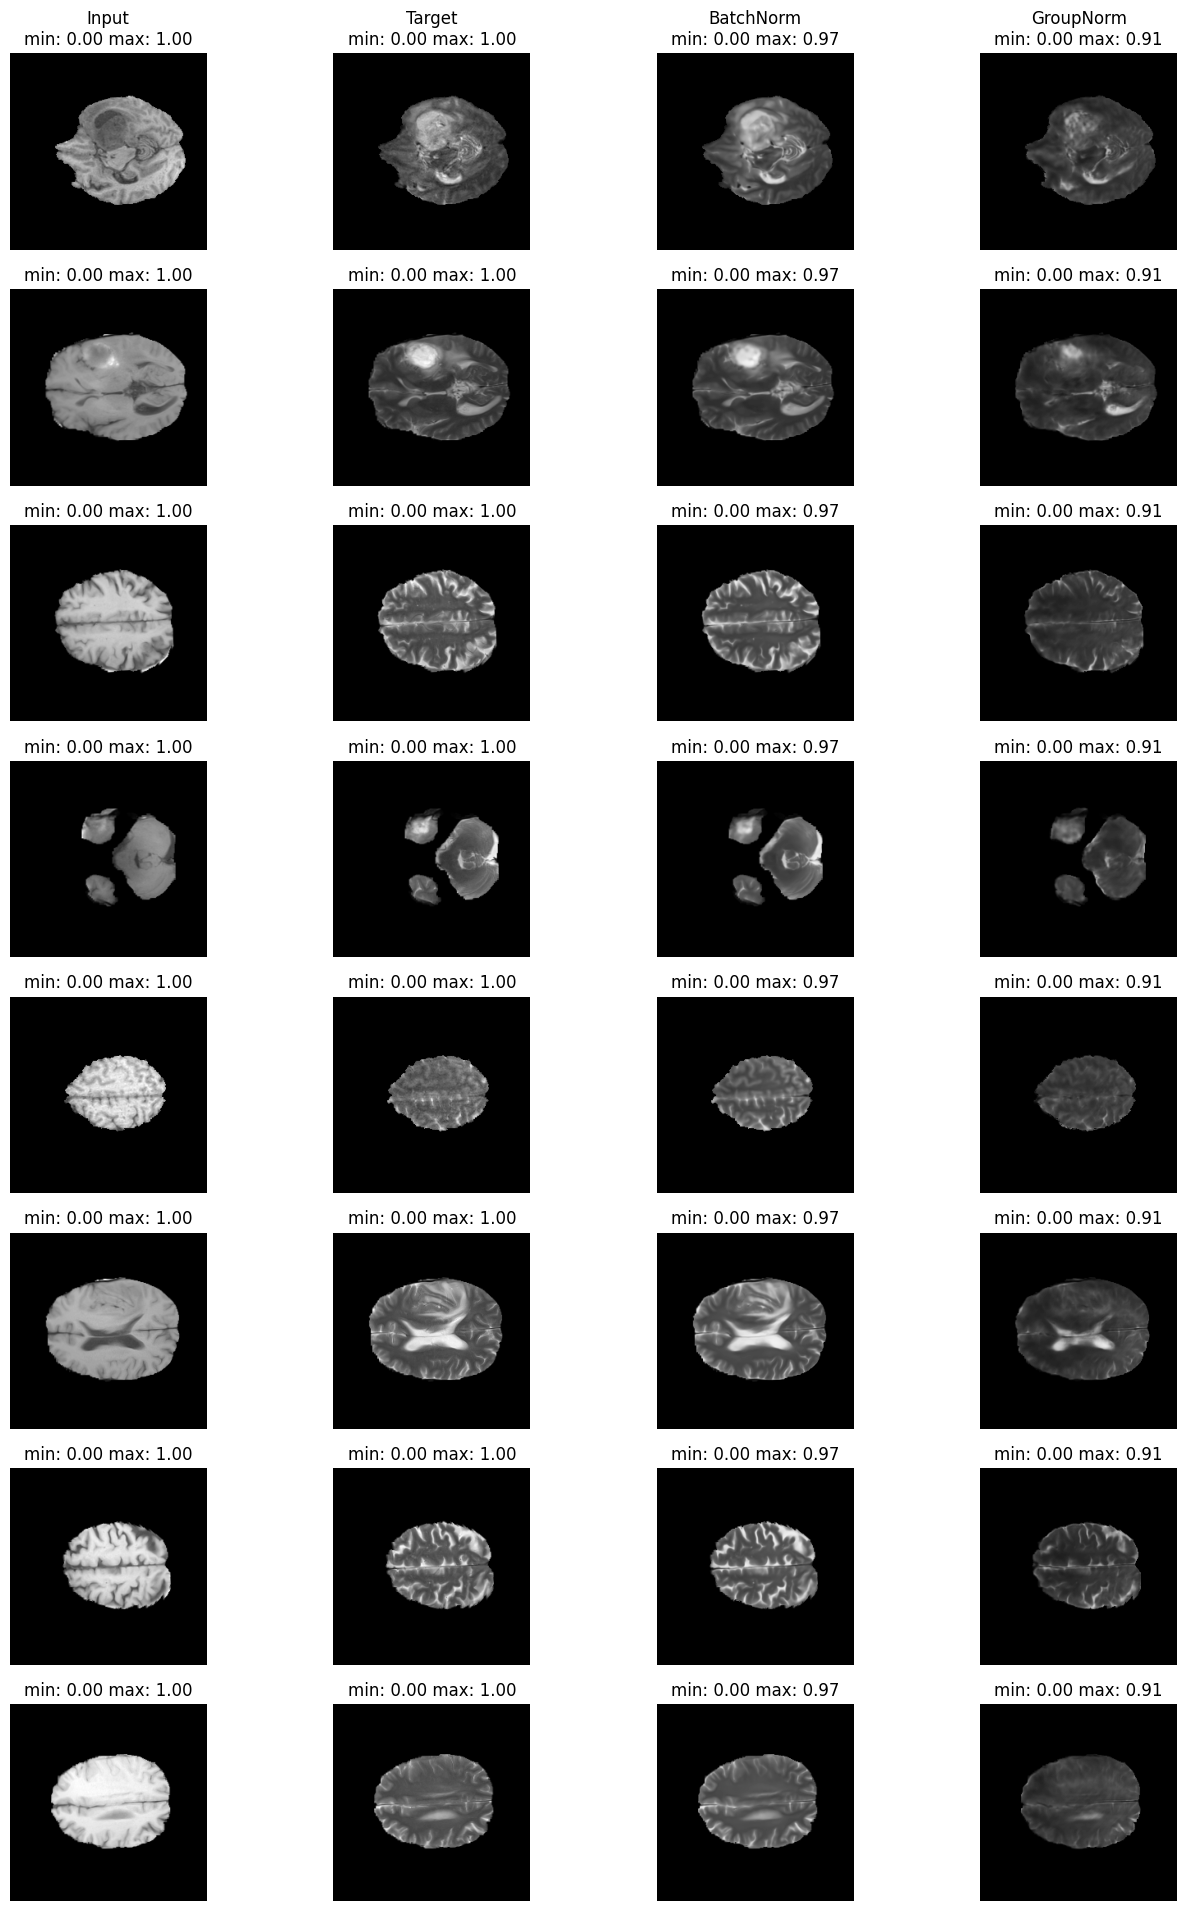

In [42]:
visualization.plot_batch([images, labels, predictions_fl_bn.detach(), predictions_fl_gn.detach()], ["Input", "Target", "BatchNorm", "GroupNorm"])

# Batch Norm DSSIM

In [12]:
bn_dssim_model_dir = "../trained_models/server/model-cent-ep128-BN"
# bn_dssim_model_dir = "../trained_models/client/model-lr0.001-ep128-2023-07-26-18_15_custom_loss"
os.listdir(bn_dssim_model_dir)

['history.pkl', 'model.pth']

In [13]:
with open(f"{bn_dssim_model_dir}/history.pkl", 'rb') as f:
    history = pickle.load(f)

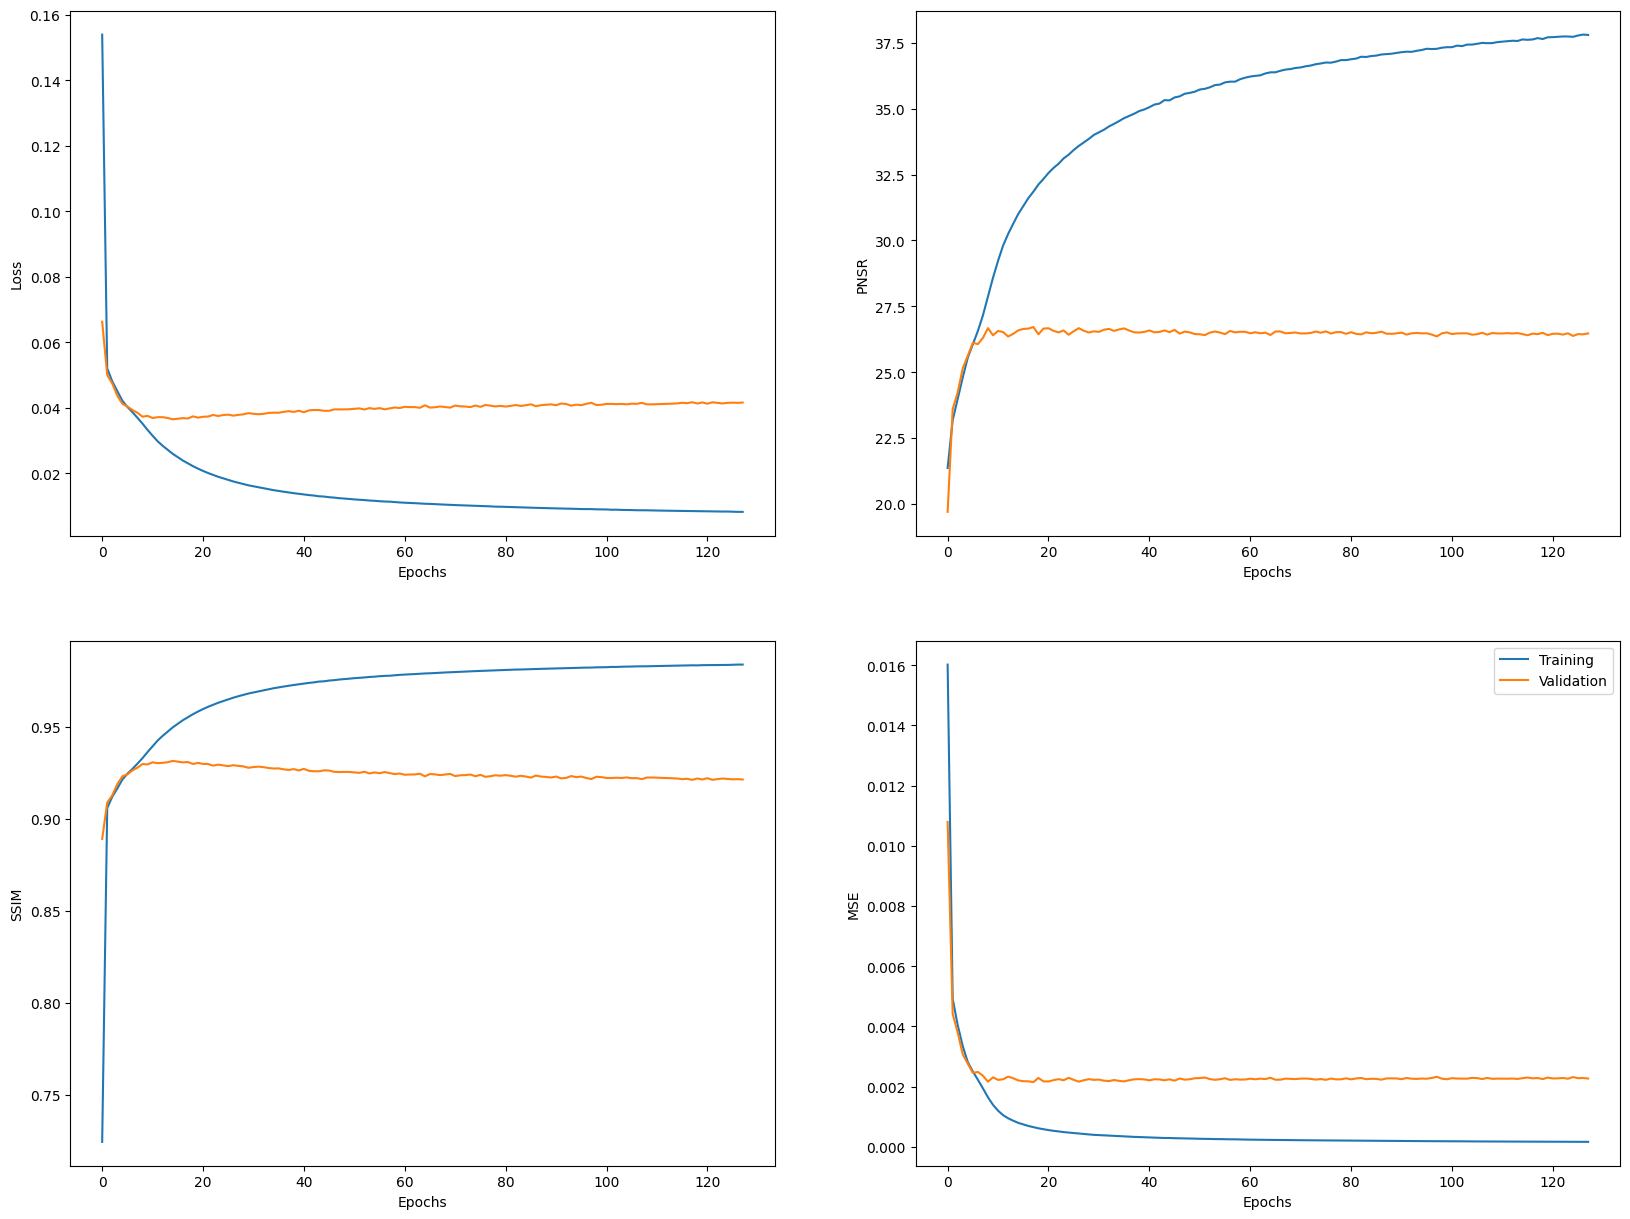

In [14]:
plot_history(history)

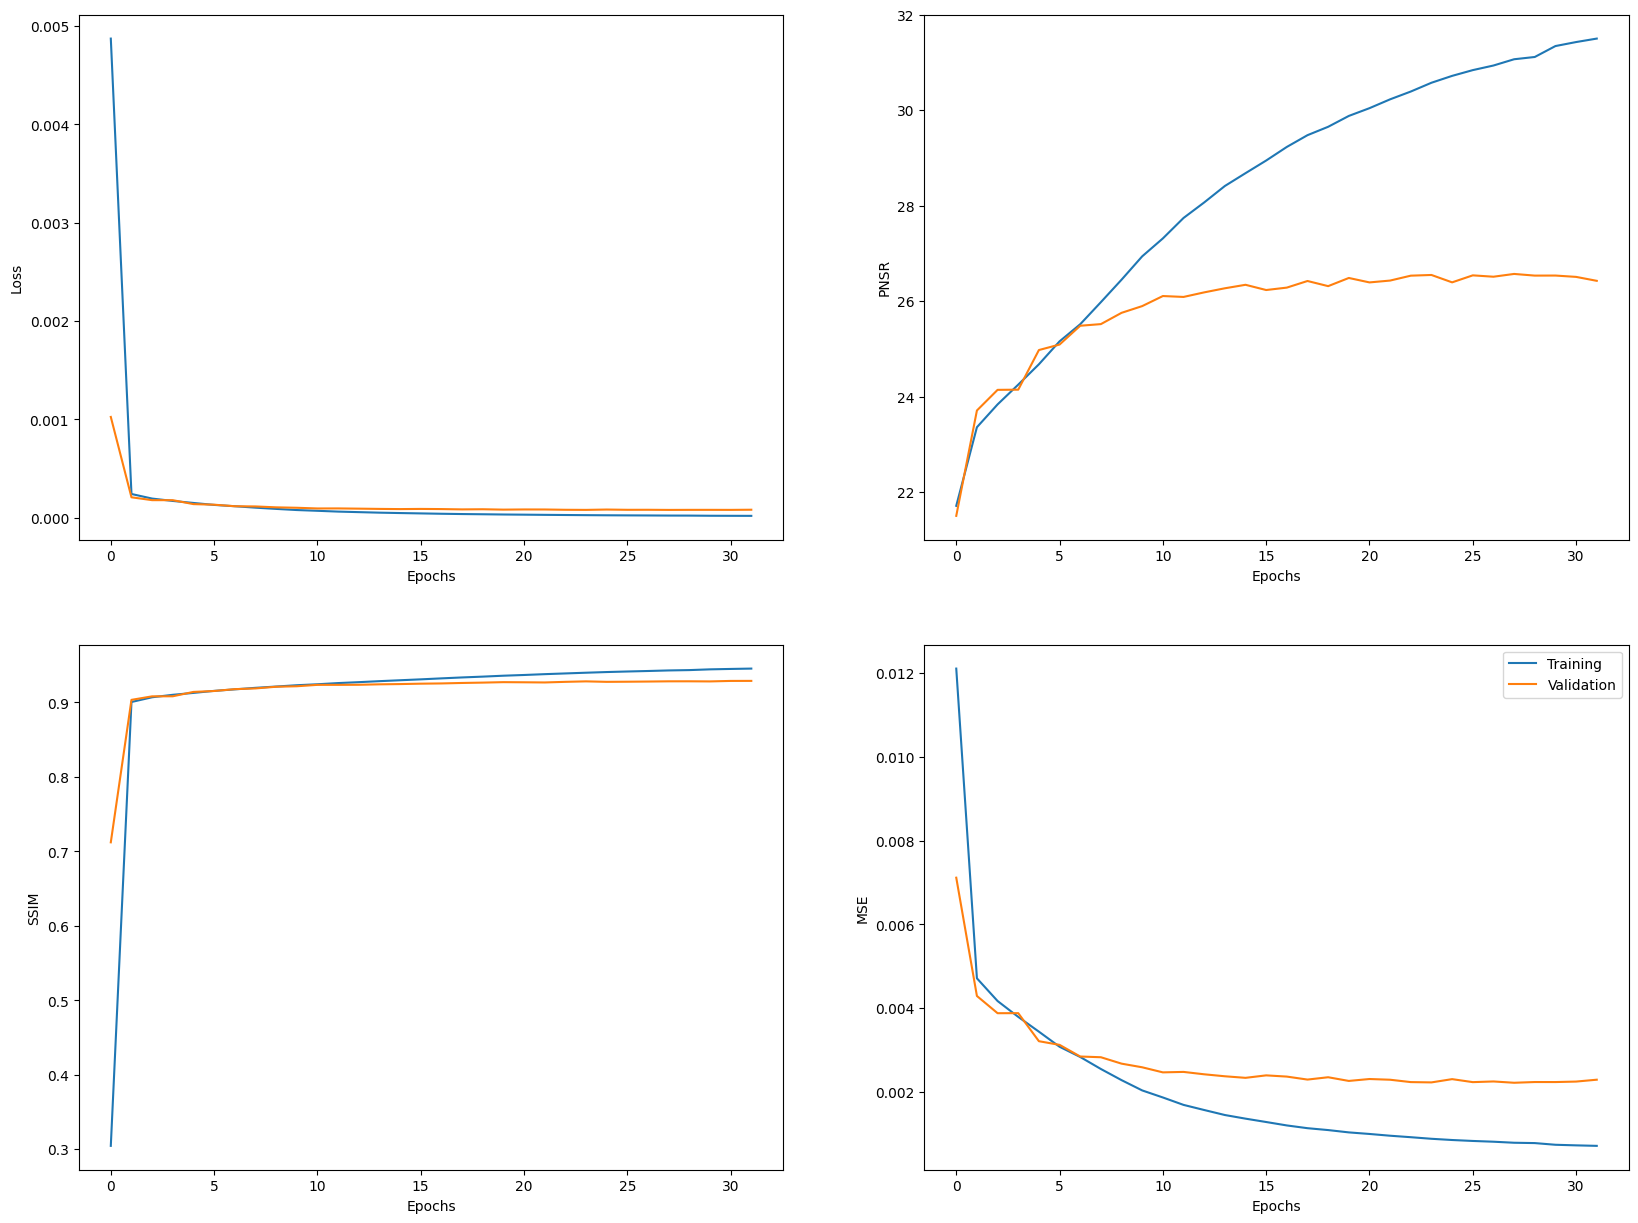

In [15]:
plot_history(history)

In [15]:
unet = models.UNet(normalization=NormalizationType.BN)
unet.load_state_dict(torch.load(f"{bn_dssim_model_dir}/model.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [18]:
predictions_fl = unet(images)

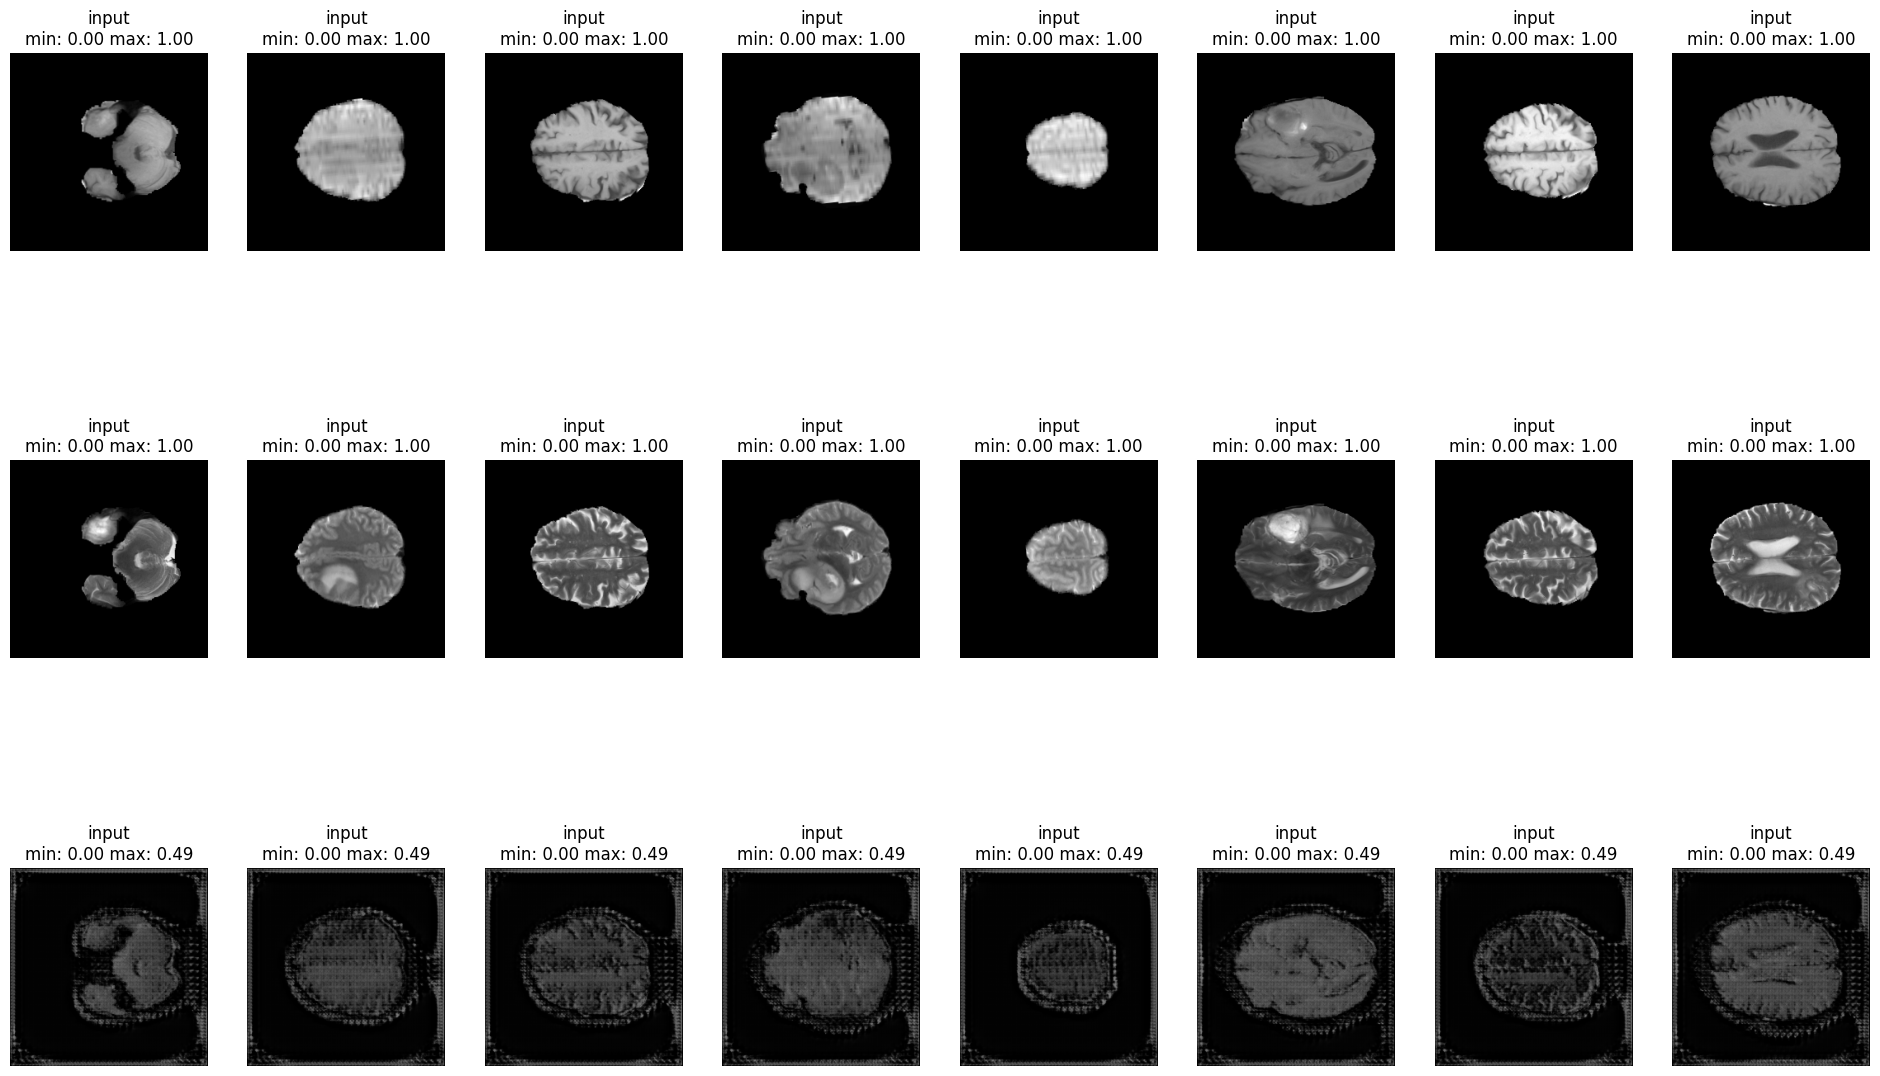

In [17]:
visualization.plot_batch([images, labels, predictions_fl.detach()])

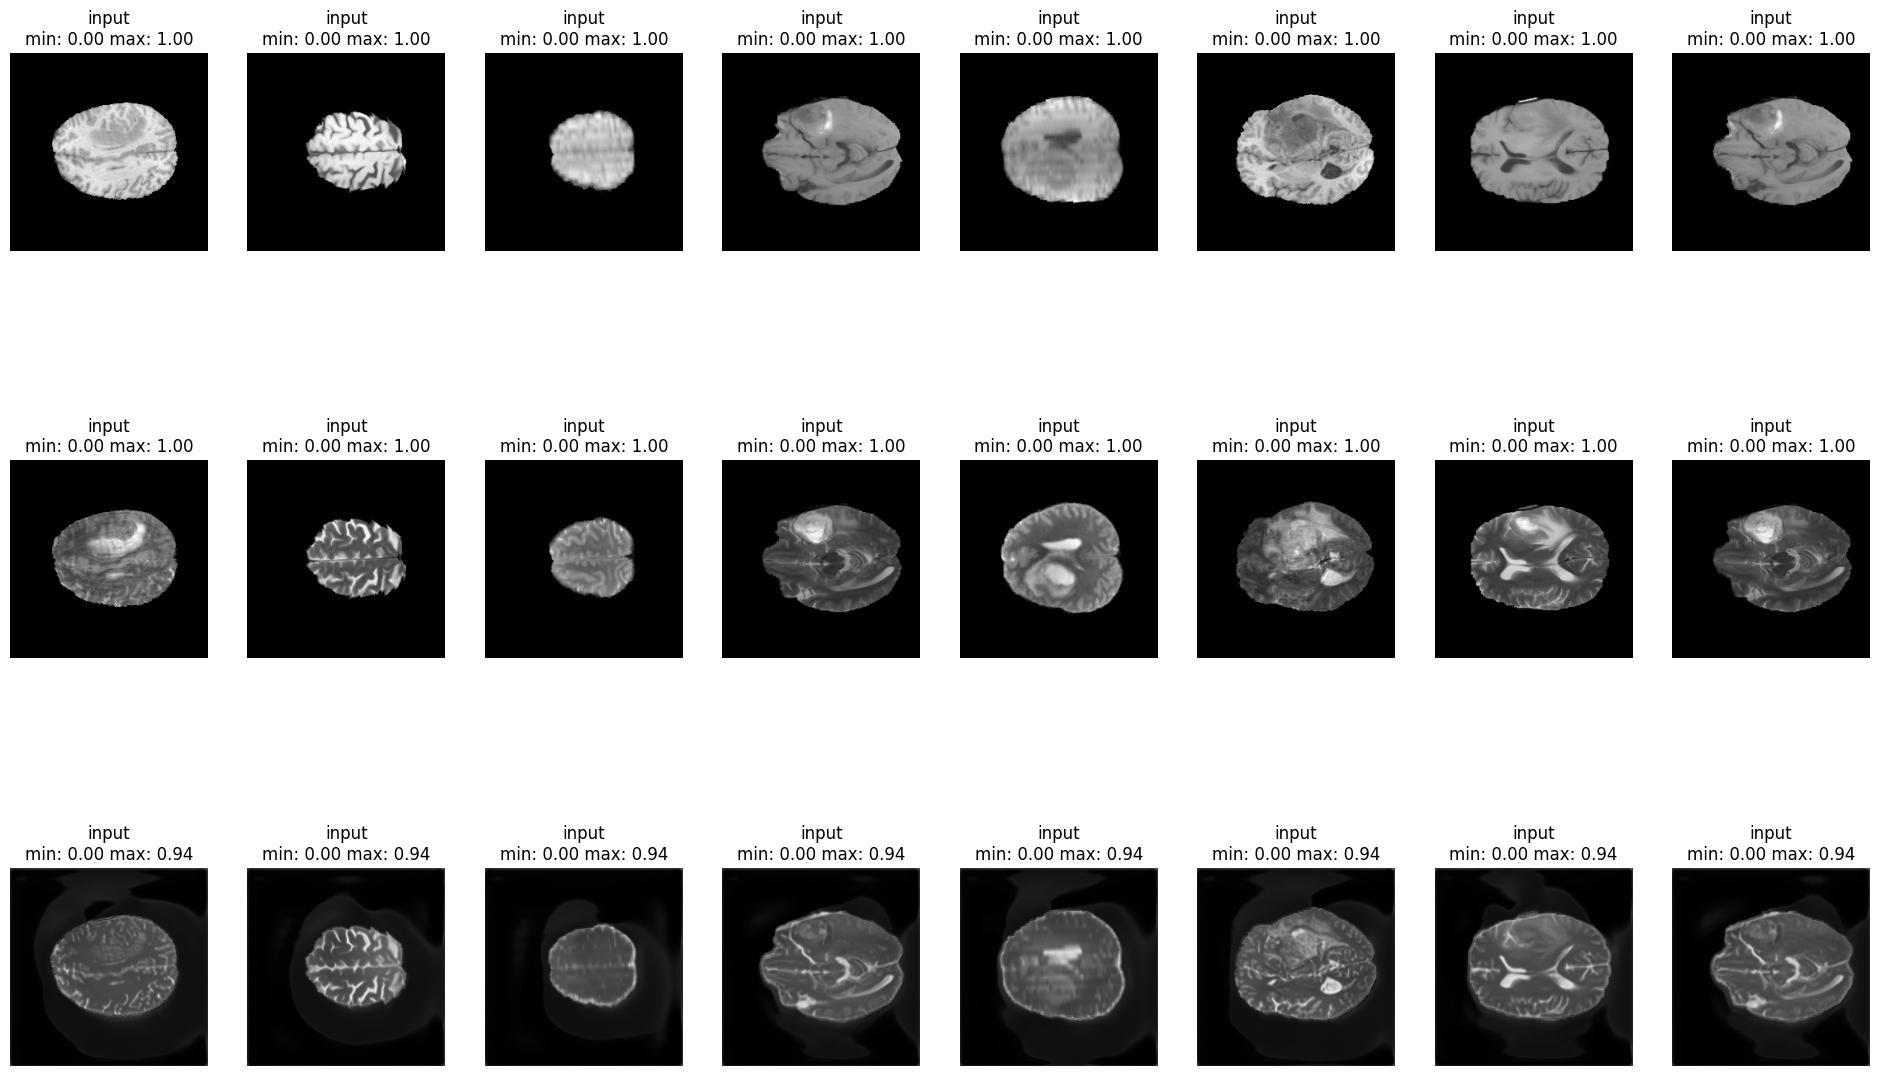

In [143]:
visualization.plot_batch([images, labels, predictions_fl.detach()])

# Without normalization

In [16]:
none_dssim_model_dir = "../trained_models/server/model-centralized-ep32-lr0.001-NONE-2023-08-23-12h"
os.listdir(none_dssim_model_dir)

['history.pkl', 'model.pth', 'predictions']

In [17]:
with open(f"{none_dssim_model_dir}/history.pkl", 'rb') as f:
    history = pickle.load(f)

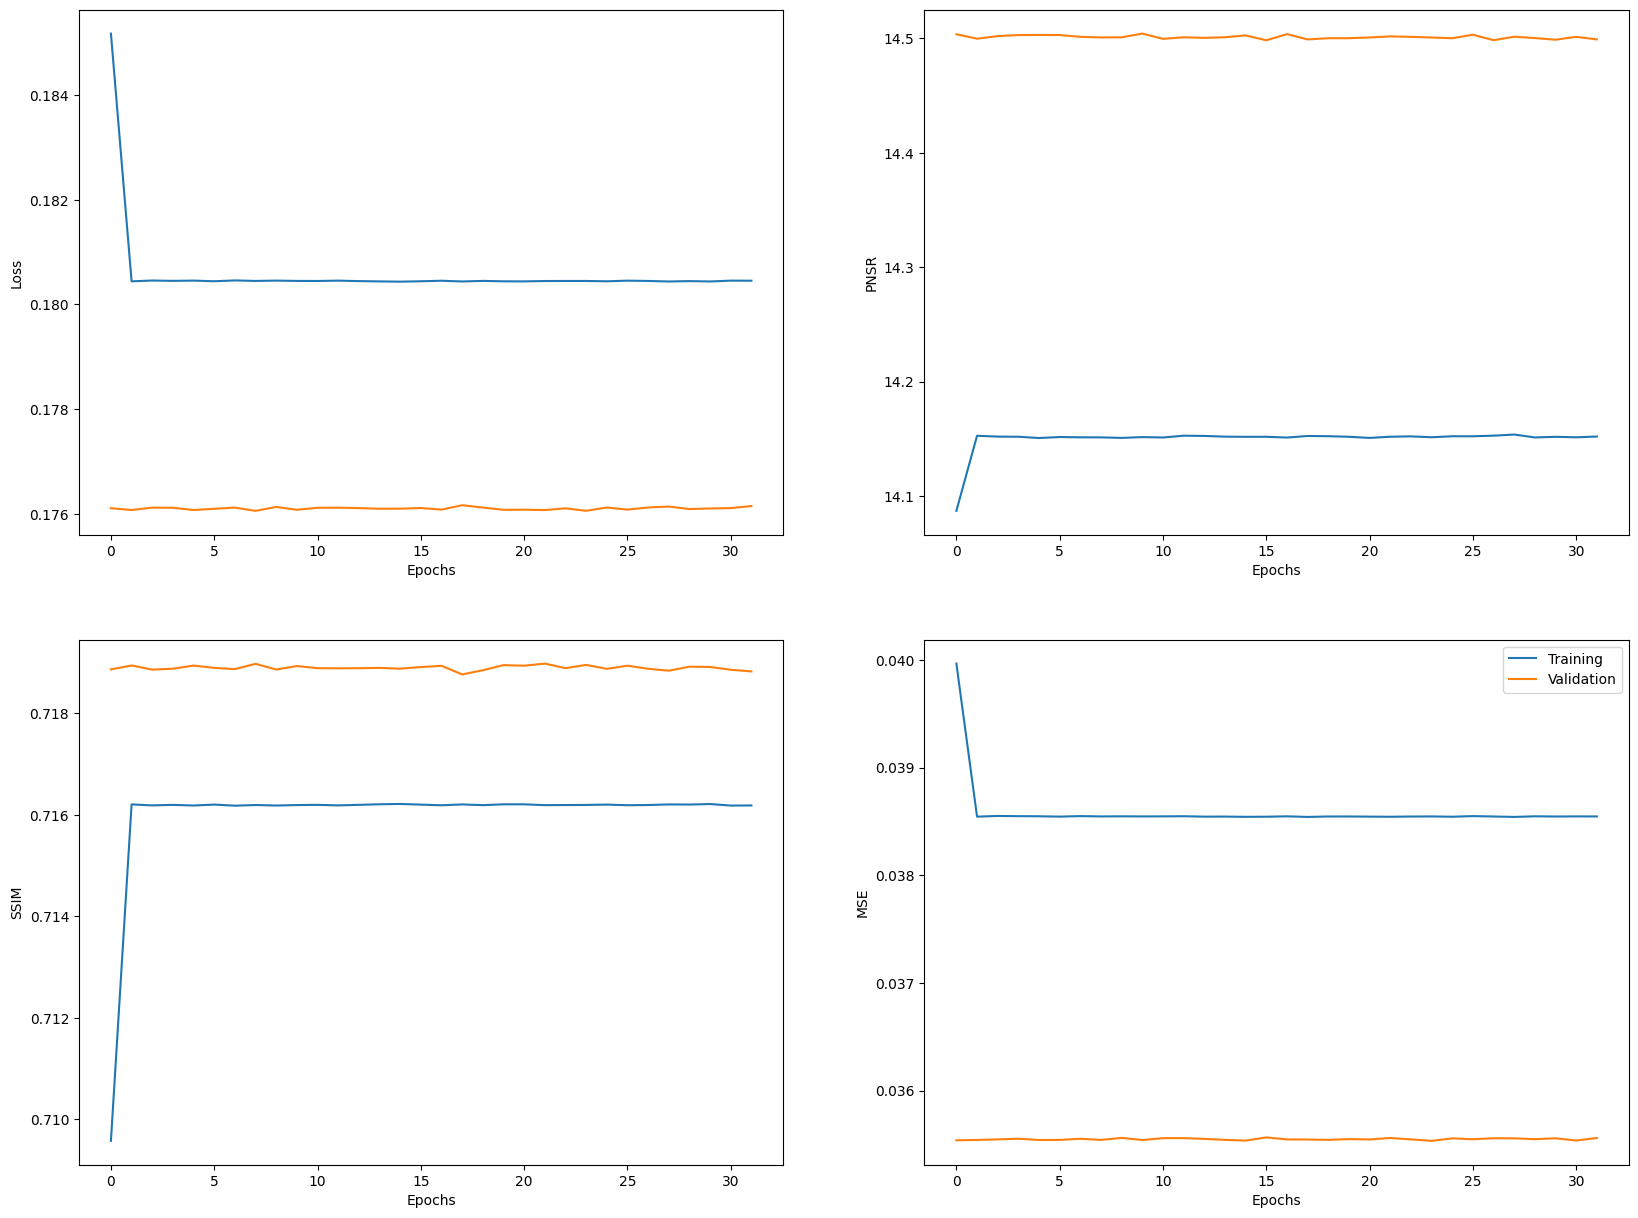

In [18]:
plot_history(history)

In [19]:
unet = models.UNet(normalization=NormalizationType.NONE)
unet.load_state_dict(torch.load(f"{none_dssim_model_dir}/model.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [10]:
predictions_fl = unet(images)

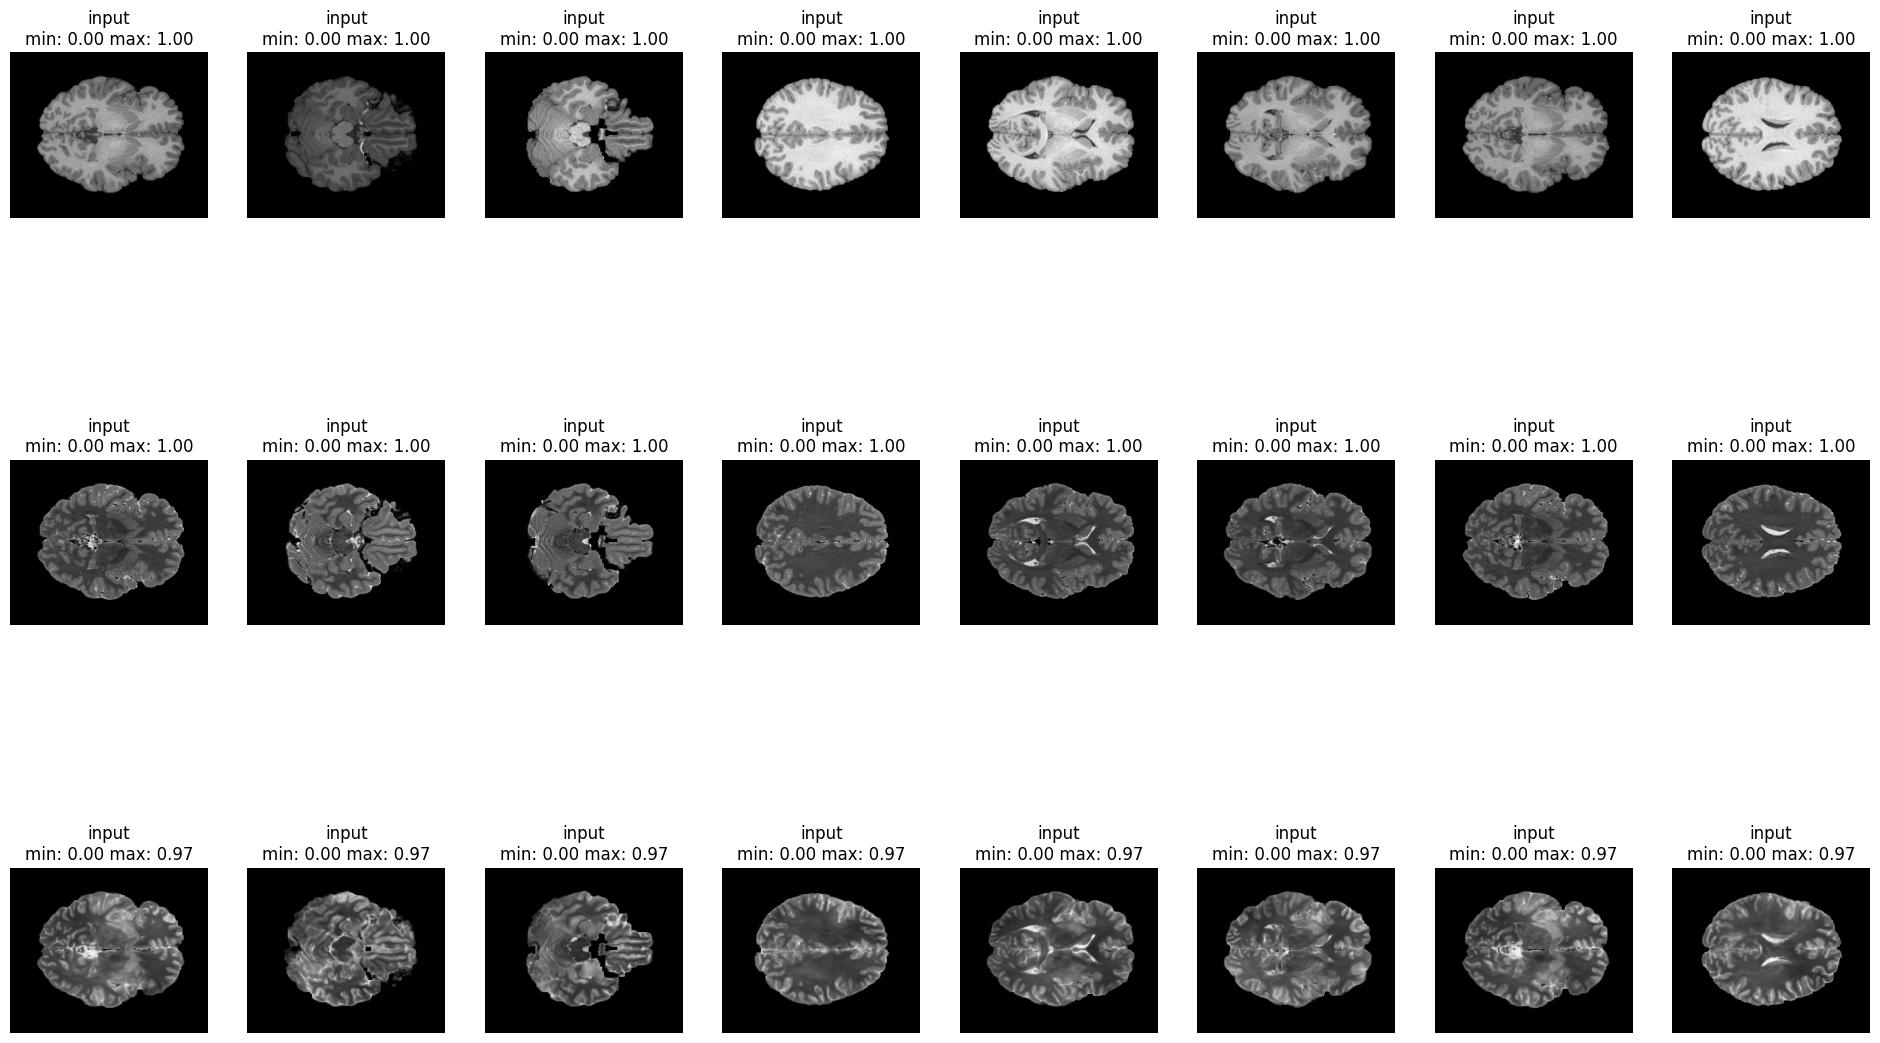

In [14]:
visualization.plot_batch([images, labels, predictions_fl.detach()])

# Old model newly trained

In [32]:
none_dssim_model_dir = "../trained_models/server/model-centralized-ep32-BN-2023-08-25-12h"
os.listdir(none_dssim_model_dir)

['history.pkl', 'model.pth', 'predictions']

In [33]:
with open(f"{none_dssim_model_dir}/history.pkl", 'rb') as f:
    history = pickle.load(f)

KeyError: 'mse'

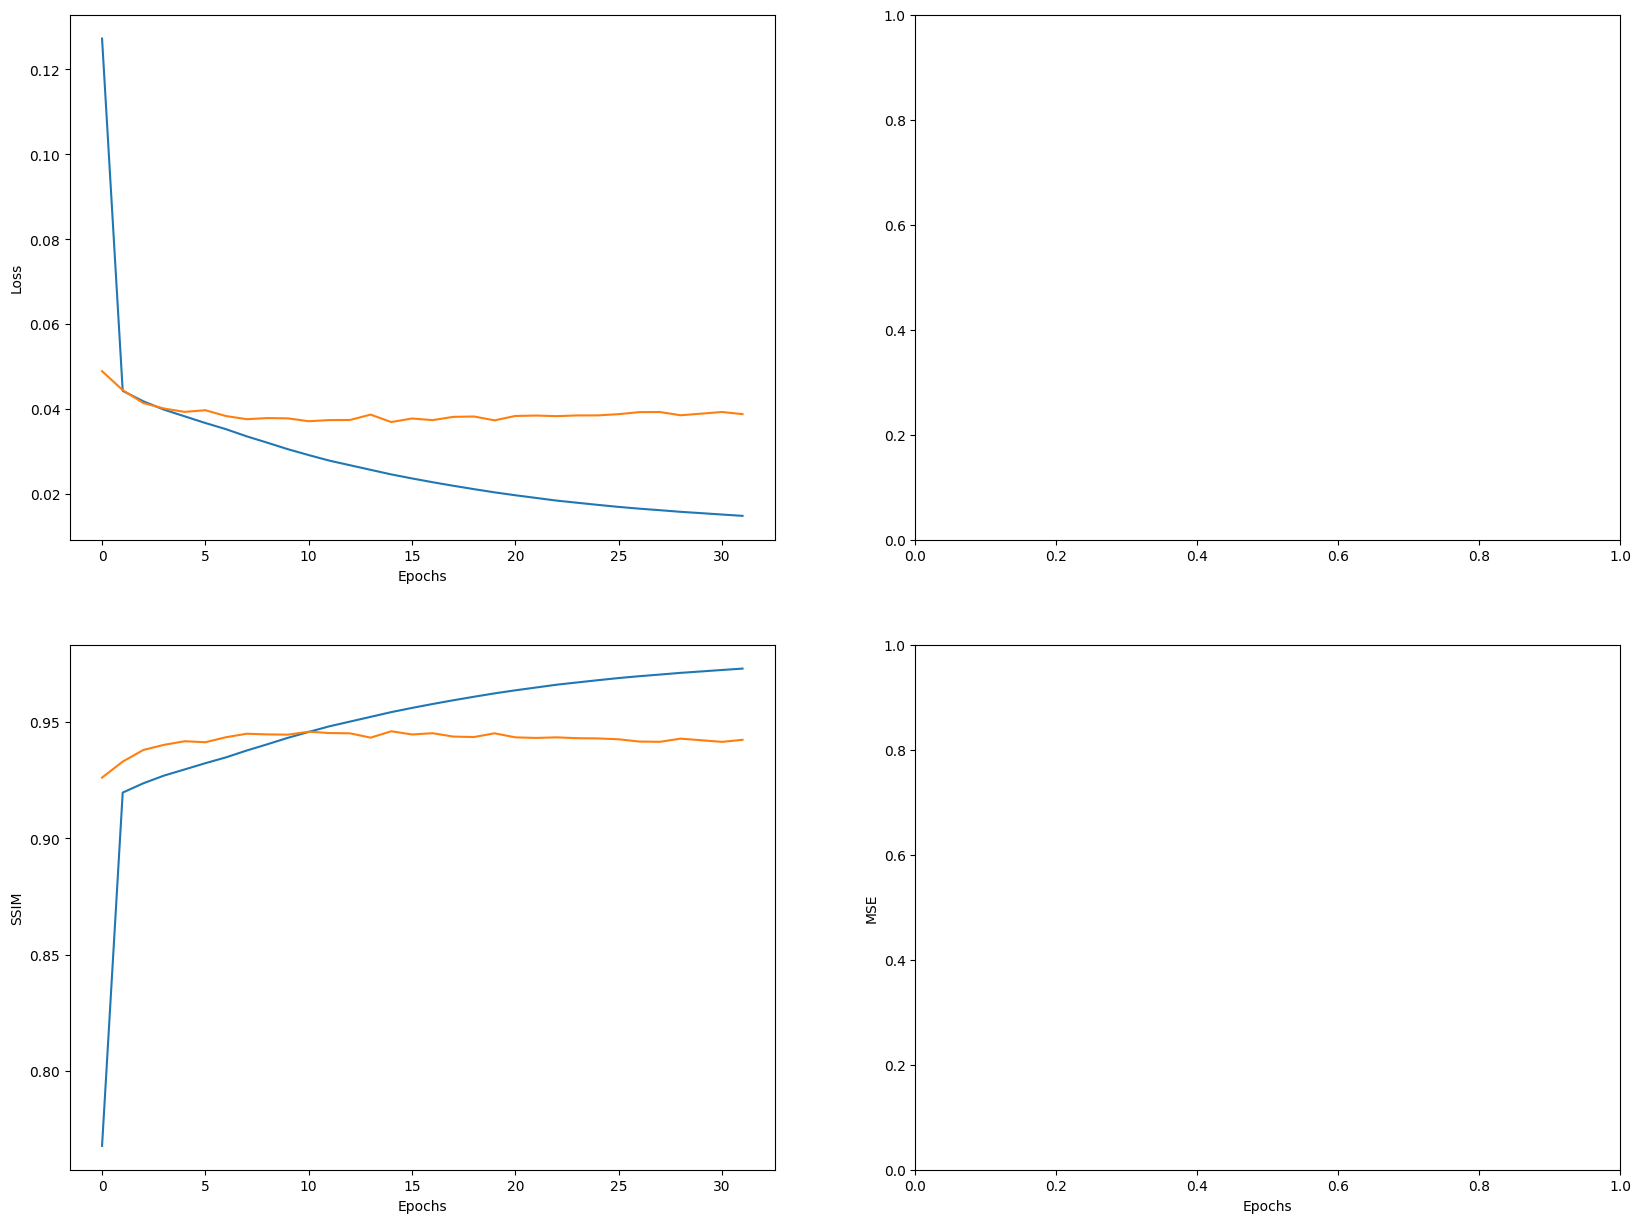

In [34]:
plot_history(history)

In [35]:
unet = models.OldUNet()
unet.load_state_dict(torch.load(f"{none_dssim_model_dir}/model.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [36]:
predictions_fl = unet(images)

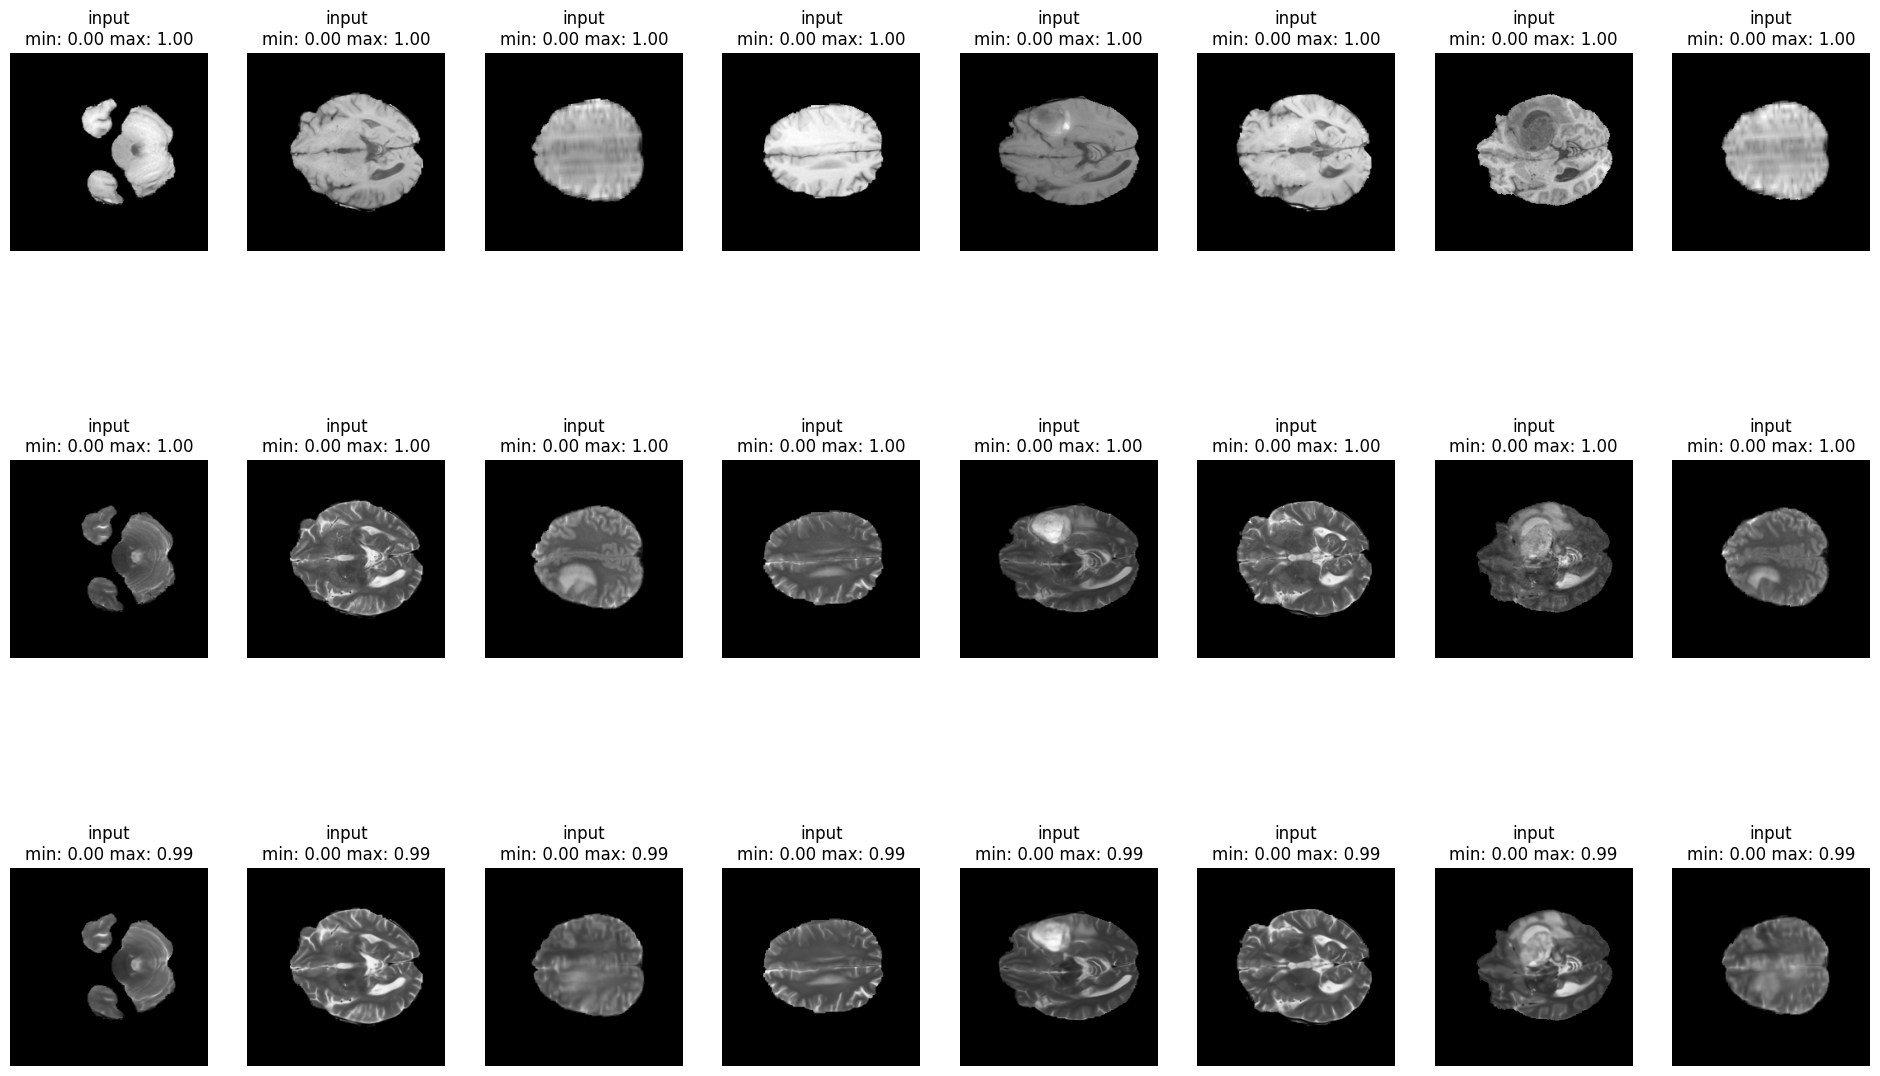

In [37]:
visualization.plot_batch([images, labels, predictions_fl.detach()])

# Old Unet2

In [5]:
none_dssim_model_dir = "../trained_models/server/model-centralized-ep32-lr0.001-BN-2023-08-25-14h"
os.listdir(none_dssim_model_dir)

['history.pkl', 'model.pth', 'predictions', 'test_hgg_loss_0.04_ssim0.93.jpg']

In [6]:
with open(f"{none_dssim_model_dir}/history.pkl", 'rb') as f:
    history = pickle.load(f)

KeyError: 'mse'

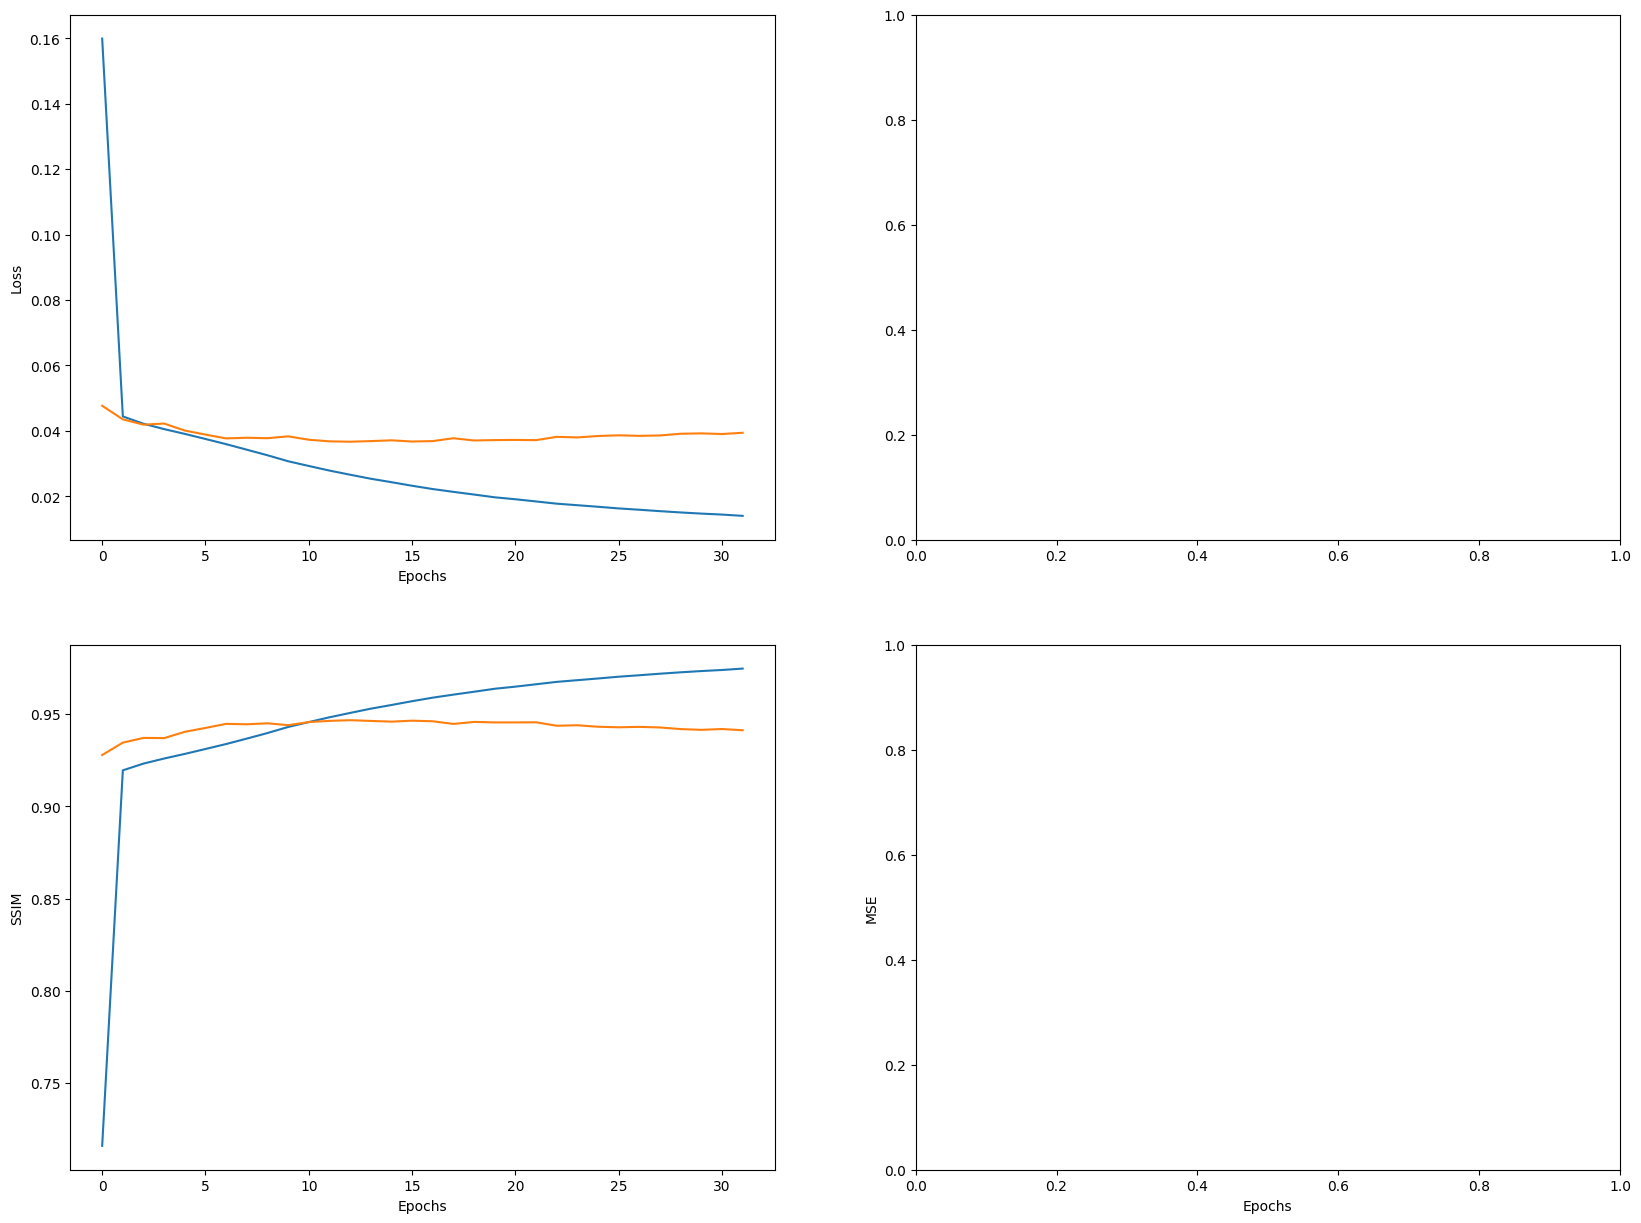

In [7]:
plot_history(history)

In [9]:
unet = models.OldUNet()
unet.load_state_dict(torch.load(f"{none_dssim_model_dir}/model.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [10]:
predictions_fl = unet(images)

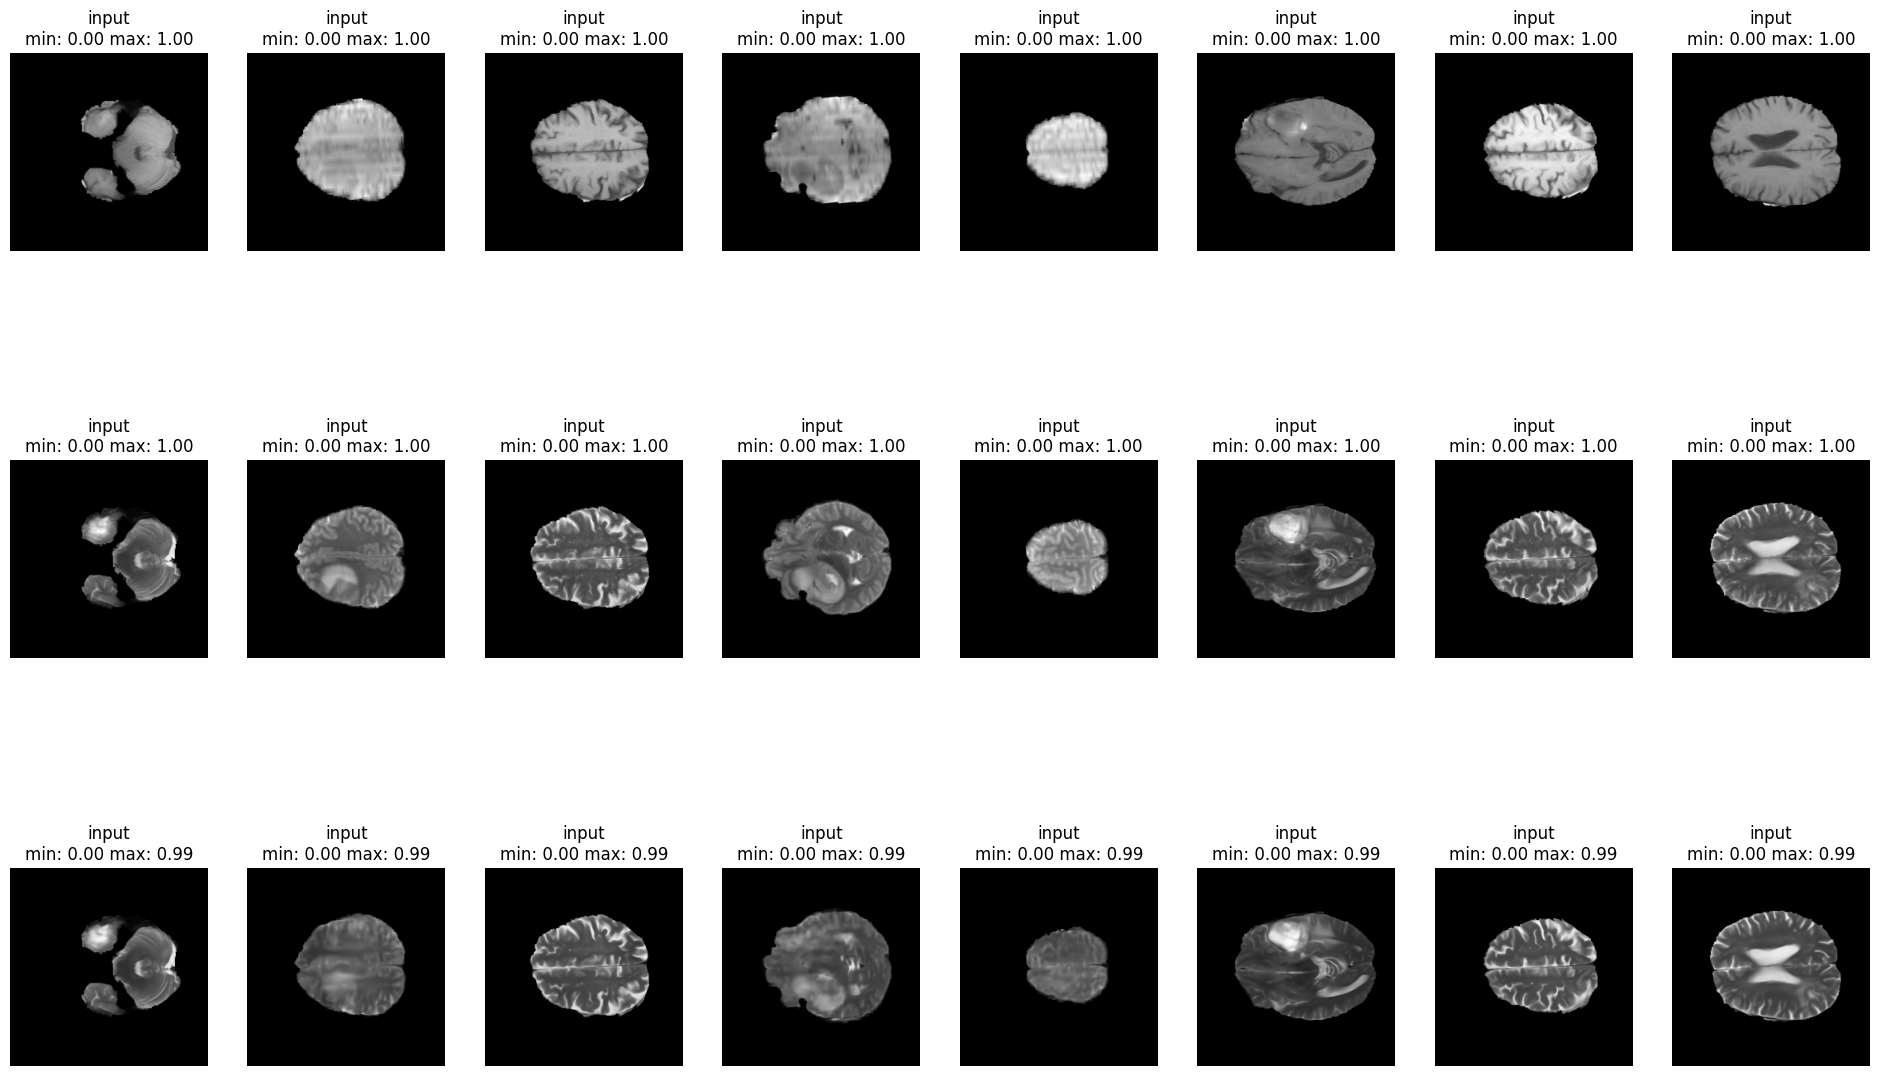

In [11]:
visualization.plot_batch([images, labels, predictions_fl.detach()])

# Old Unet 4

In [9]:
none_dssim_model_dir = "../trained_models/server/model-centralized-ep32-lr0.001-BN-2023-08-25-17h"
os.listdir(none_dssim_model_dir)

['history.pkl', 'model.pth', 'predictions']

In [10]:
with open(f"{none_dssim_model_dir}/history.pkl", 'rb') as f:
    history = pickle.load(f)

KeyError: 'mse'

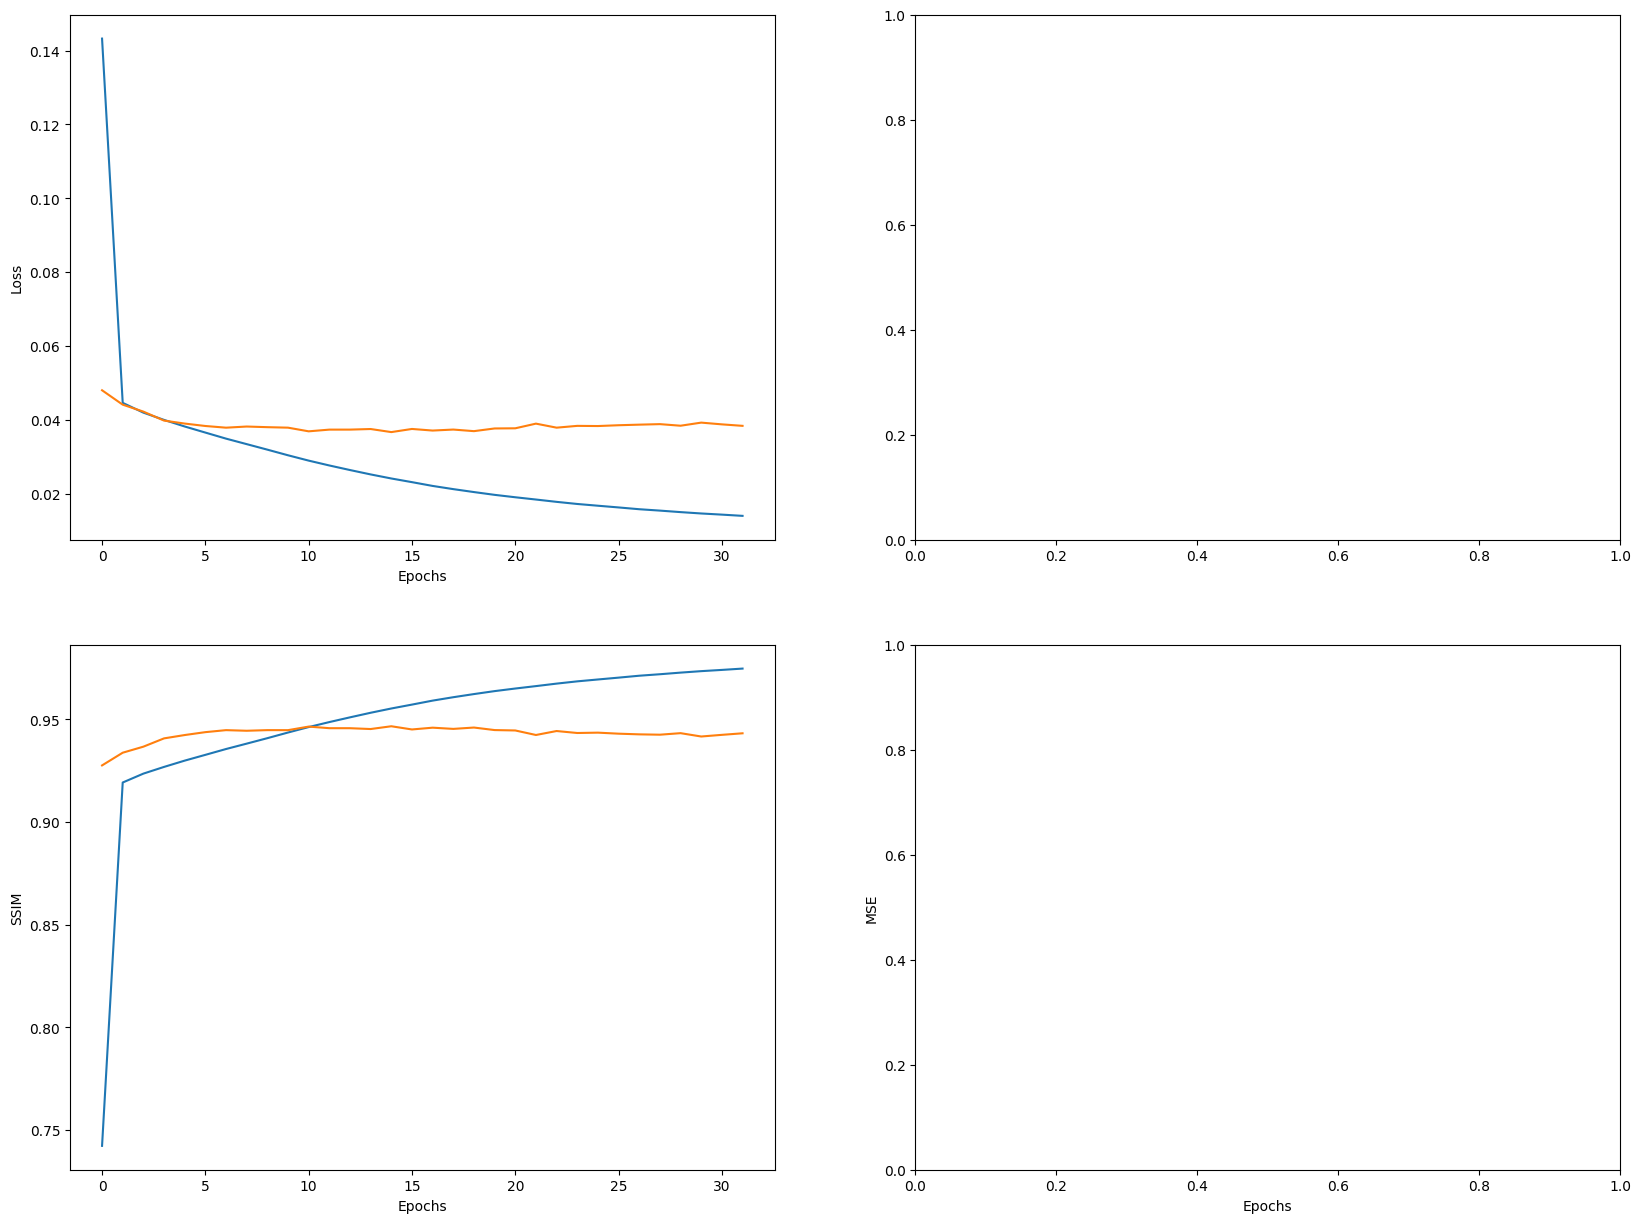

In [11]:
plot_history(history)

In [12]:
unet = models.OldUNet()
unet.load_state_dict(torch.load(f"{none_dssim_model_dir}/model.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [13]:
predictions_fl = unet(images)

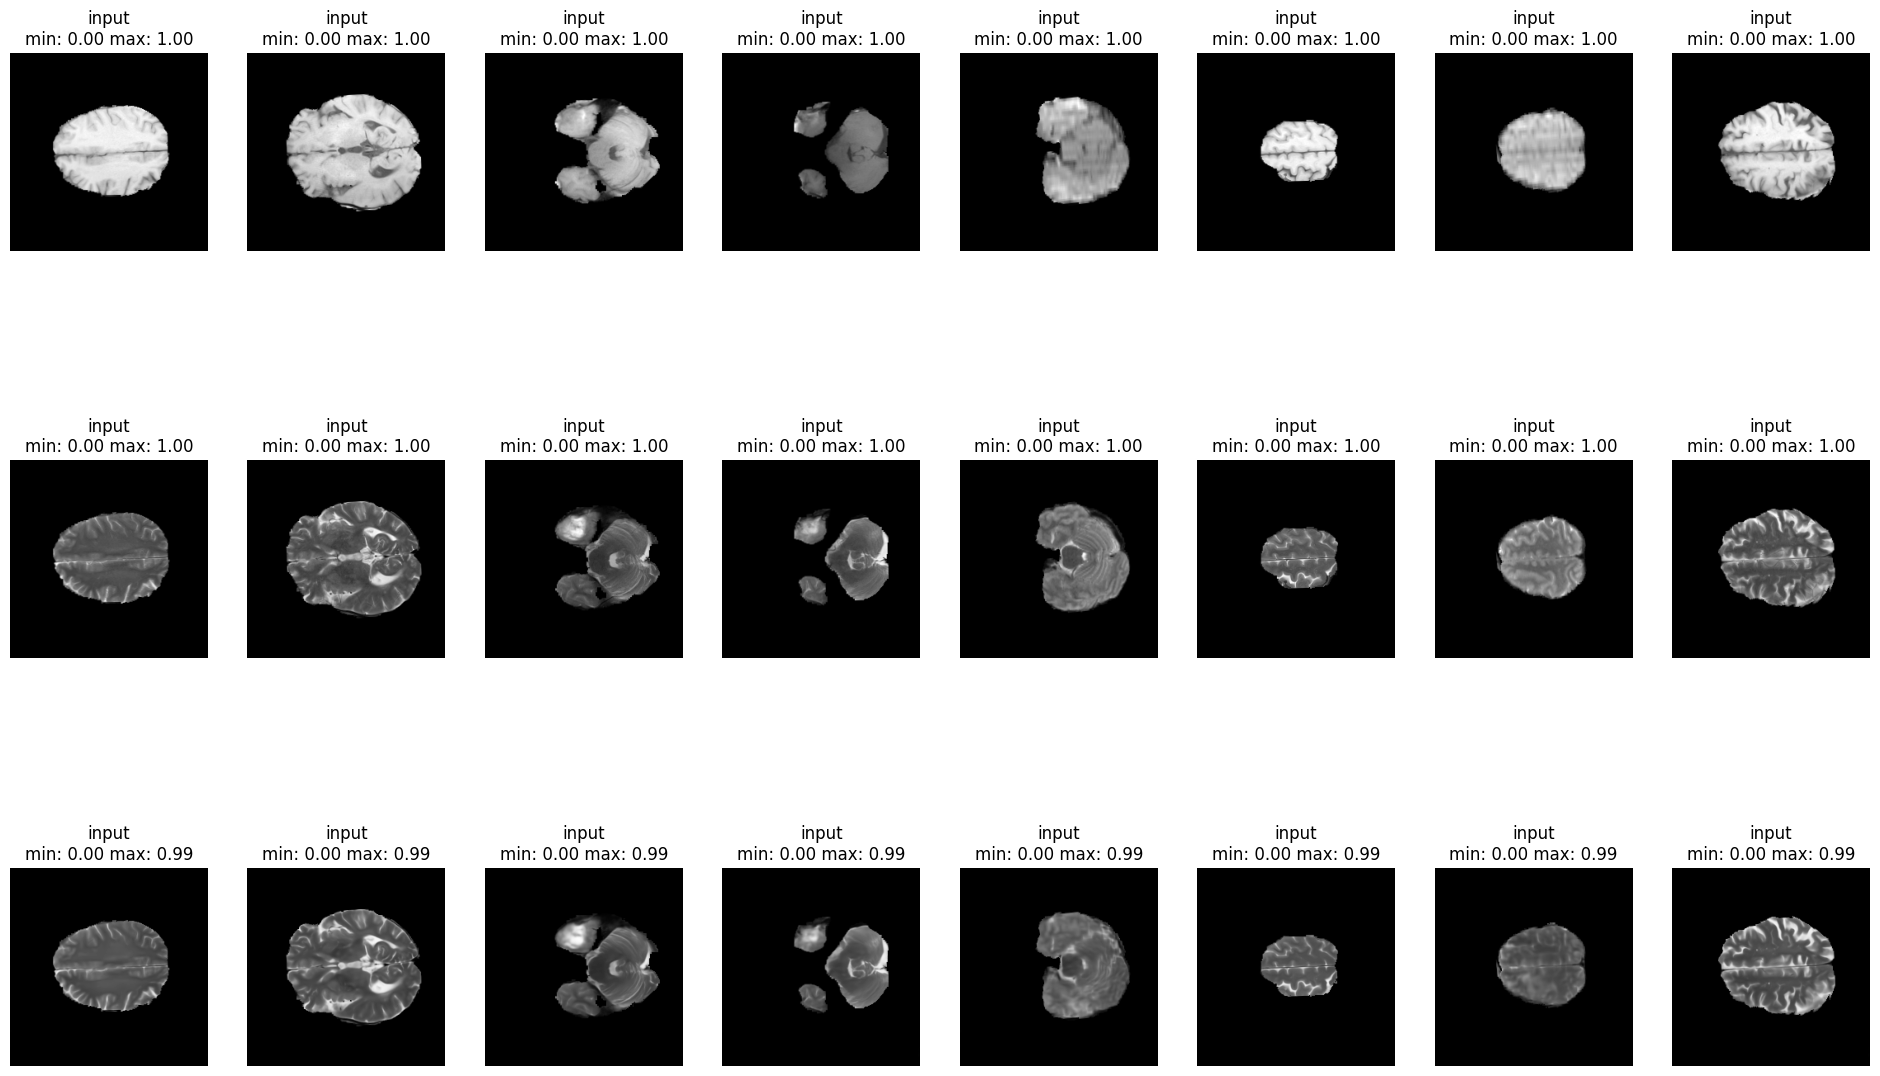

In [14]:
visualization.plot_batch([images, labels, predictions_fl.detach()])

# OLD OLD

In [28]:
from os import path
import pickle
import time
from typing import Callable

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchmetrics.image import StructuralSimilarityIndexMeasure

import src.loss_functions
from configs import config_train
from src import visualization, files_operations as fop

model_dir = config_train.TRAINED_MODEL_SERVER_DIR
device = config_train.DEVICE
batch_print_freq = config_train.BATCH_PRINT_FREQ
ssim = StructuralSimilarityIndexMeasure(data_range=1).to(device)

class UNet(nn.Module):
    # TODO: test with bilinear = False
    def __init__(self, bilinear=False):
        super(UNet, self).__init__()

        self.inc = (DoubleConv(1, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, 1))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def _train_one_epoch(self, trainloader, optimizer, criterion, batch_print_frequency, prox_loss):
        running_loss, total_ssim = 0.0, 0.0
        epoch_loss, epoch_ssim = 0.0, 0.0

        n_batches = len(trainloader)

        start = time.time()
        n_train_steps = 0

        if prox_loss:
            global_params = [val.detach().clone() for val in self.parameters()]

        for index, data in enumerate(trainloader):
            images, targets = data
            images = images.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()

            predictions = self(images)

            if prox_loss:
                loss = criterion(predictions, targets, self.parameters(), global_params)
            else:
                loss = criterion(predictions, targets)
            loss.backward()

            optimizer.step()

            # predictions_double = predictions.double()
            # targets_double = targets.double()

            # print(f"Predictions shape: {predictions_double.shape} type: {predictions_double.type()}")
            # print(f"Targets shape: {targets_double.shape} type: {targets_double.type()}")

            ssim_value = ssim(predictions, targets)

            running_loss += loss.item()
            total_ssim += ssim_value.item()

            epoch_loss += loss.item()
            epoch_ssim += ssim_value.item()

            n_train_steps += 1

            if index % batch_print_frequency == batch_print_frequency - 1:
                print(f'\tbatch {(index + 1)} out of {n_batches}\t'
                      f'loss: {running_loss / batch_print_frequency:.3f} '
                      f'ssim {total_ssim / batch_print_frequency:.3f}')

                running_loss = 0.0
                total_ssim = 0.0

        epoch_loss /= n_train_steps
        epoch_ssim /= n_train_steps
        print(f"\n\tTime exceeded: {time.time() - start:.1f} "
              f"epoch loss: {epoch_loss:.3f} ssim: {epoch_ssim:.3f}")
        print()

        return epoch_loss, epoch_ssim

    def perform_train(self,
                      trainloader: DataLoader,
                      optimizer,
                      criterion,
                      epochs,
                      prox_loss=False,
                      validationloader=None,
                      model_dir=config_train.TRAINED_MODEL_SERVER_DIR,
                      filename=None,
                      history_filename=None,
                      plots_dir=None):
        print(f"TRAINING... \n\ton device: {device} \n\twith loss: {criterion}\n")

        if not isinstance(criterion, Callable):
            raise TypeError(f"Loss function (criterion) has to be callable. It is {type(criterion)} which is not.")

        if any([history_filename, plots_dir, filename]):
            fop.try_create_dir(model_dir)
            print(f"\tModel, history and plots will be saved to {model_dir}")
        else:
            print(f"\tWARNING: Neither model, history nor plots from the training process will be saved!")

        n_batches = len(trainloader)

        if batch_print_freq > n_batches:
            print_freq = n_batches - 2  # tbh not sure if this -2 is needed
        else:
            print_freq = batch_print_freq

        train_losses = []
        train_ssims = []
        val_losses = []
        val_ssims = []

        if plots_dir is not None:
            plots_path = path.join(model_dir, plots_dir)
            fop.try_create_dir(plots_path)

        self.train()

        for epoch in range(epochs):
            print(f"\tEPOCH: {epoch + 1}/{epochs}")

            epoch_loss, epoch_ssim = self._train_one_epoch(trainloader, optimizer, criterion, print_freq, prox_loss)

            train_ssims.append(epoch_ssim)
            train_losses.append(epoch_loss)

            print("\tVALIDATION...")
            if validationloader is not None:
                val_loss, val_ssim = self.evaluate(validationloader, criterion, model_dir, plots_dir, f"ep{epoch}")

                val_ssims.append(val_ssim)
                val_losses.append(val_loss)

        print("\tAll epochs finished.\n")

        history = {"loss": train_losses, "ssim": train_ssims, "val_loss": val_losses, "val_ssim": val_ssims}

        # saving
        if history_filename is not None:
            with open(path.join(model_dir, history_filename), 'wb') as file:
                pickle.dump(history, file)

        if filename is not None:
            self.save(model_dir, filename)

        return history

    def evaluate(self, testloader, criterion, model_dir=config_train.TRAINED_MODEL_SERVER_DIR, plots_dir=None, plot_filename=None):
        if isinstance(criterion, src.loss_functions.LossWithProximalTerm):
            criterion = criterion.base_loss_fn

        print(f"\tON DEVICE: {device} \n\tWITH LOSS: {criterion}\n")

        if not isinstance(criterion, Callable):
            raise TypeError(f"Loss function (criterion) has to be callable. It is {type(criterion)} which is not.")

        n_test_steps = 0

        test_loss = 0.0
        test_ssim = 0.0

        self.eval()
        with torch.no_grad():
            for images_cpu, targets_cpu in testloader:
                images = images_cpu.to(device)
                targets = targets_cpu.to(device)

                predictions = self.__call__(images)
                loss = criterion(predictions, targets)

                test_loss += loss.item()
                test_ssim += ssim(predictions, targets).item()

                n_test_steps += 1

        test_loss /= n_test_steps
        test_ssim /= n_test_steps

        print(f"\tFor evaluation set: test_loss: {test_loss:.3f} "
              f"test_ssim: {test_ssim:.3f}\n")

        if plots_dir is not None:
            directory = path.join(model_dir, plots_dir)
            fop.try_create_dir(directory)
            filepath = path.join(directory, f"{plot_filename}.jpg")
            # maybe cast to cpu ?? still dunno if needed
            visualization.plot_batch([images_cpu, targets_cpu, predictions.to('cpu').detach()], filepath=filepath)

        return test_loss, test_ssim

    def save(self, dir_name: str, filename: str = None, create_dir=True):
        if filename is None:
            filename = "model"

        if not isinstance(dir_name, str):
            raise TypeError(f"Given directory name {dir_name} has wrong type: {type(dir_name)}.")

        if create_dir:
            fop.try_create_dir(dir_name)

        if not filename.endswith(".pth"):
            filename += ".pth"

        filepath = f"{dir_name}/{filename}"
        torch.save(self.state_dict(), filepath)

        print("Model saved to: ", filepath)

    def __repr__(self):
        return f"UNet(batch_norm=gegeg)"


class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()

        if not mid_channels:
            mid_channels = out_channels

        self.double_conv = nn.Sequential(nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(mid_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True))

    def forward(self, x):
        return self.double_conv(x)
    #
    #     self.norm1 = nn.GroupNorm(config_train.N_GROUP_NORM, mid_channels)
    #     self.norm2 = nn.GroupNorm(config_train.N_GROUP_NORM, out_channels)
    #
    #     self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False)
    #     self.relu = nn.ReLU(inplace=True)
    #     self.conv2 = nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False)
    #
    # def forward(self, x):
    #     x = self.conv1(x)
    #     x = self.norm1(x)
    #     x = self.relu(x)
    #
    #     x = self.conv2(x)
    #     x = self.norm2(x)
    #     x = self.relu(x)
    #
    #     return x


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return torch.sigmoid(self.conv(x))

In [25]:
bn_dssim_model_dir = "../trained_models/client/model-lr0.001-ep128-2023-07-26-18_15_custom_loss"
os.listdir(bn_dssim_model_dir)

['history.pkl',
 'model.pth',
 'predictions',
 'test_loss_hcp_mgh-0.0010_ssim-0.8301.jpg',
 'test_loss_hcp_wu_minn-0.0004_ssim-0.8573.jpg',
 'test_loss_hgg-0.0001_ssim-0.9204.jpg',
 'test_loss_lgg-0.0002_ssim-0.9069.jpg']

In [21]:
with open(f"{bn_dssim_model_dir}/history.pkl", 'rb') as f:
    history = pickle.load(f)

KeyError: 'mse'

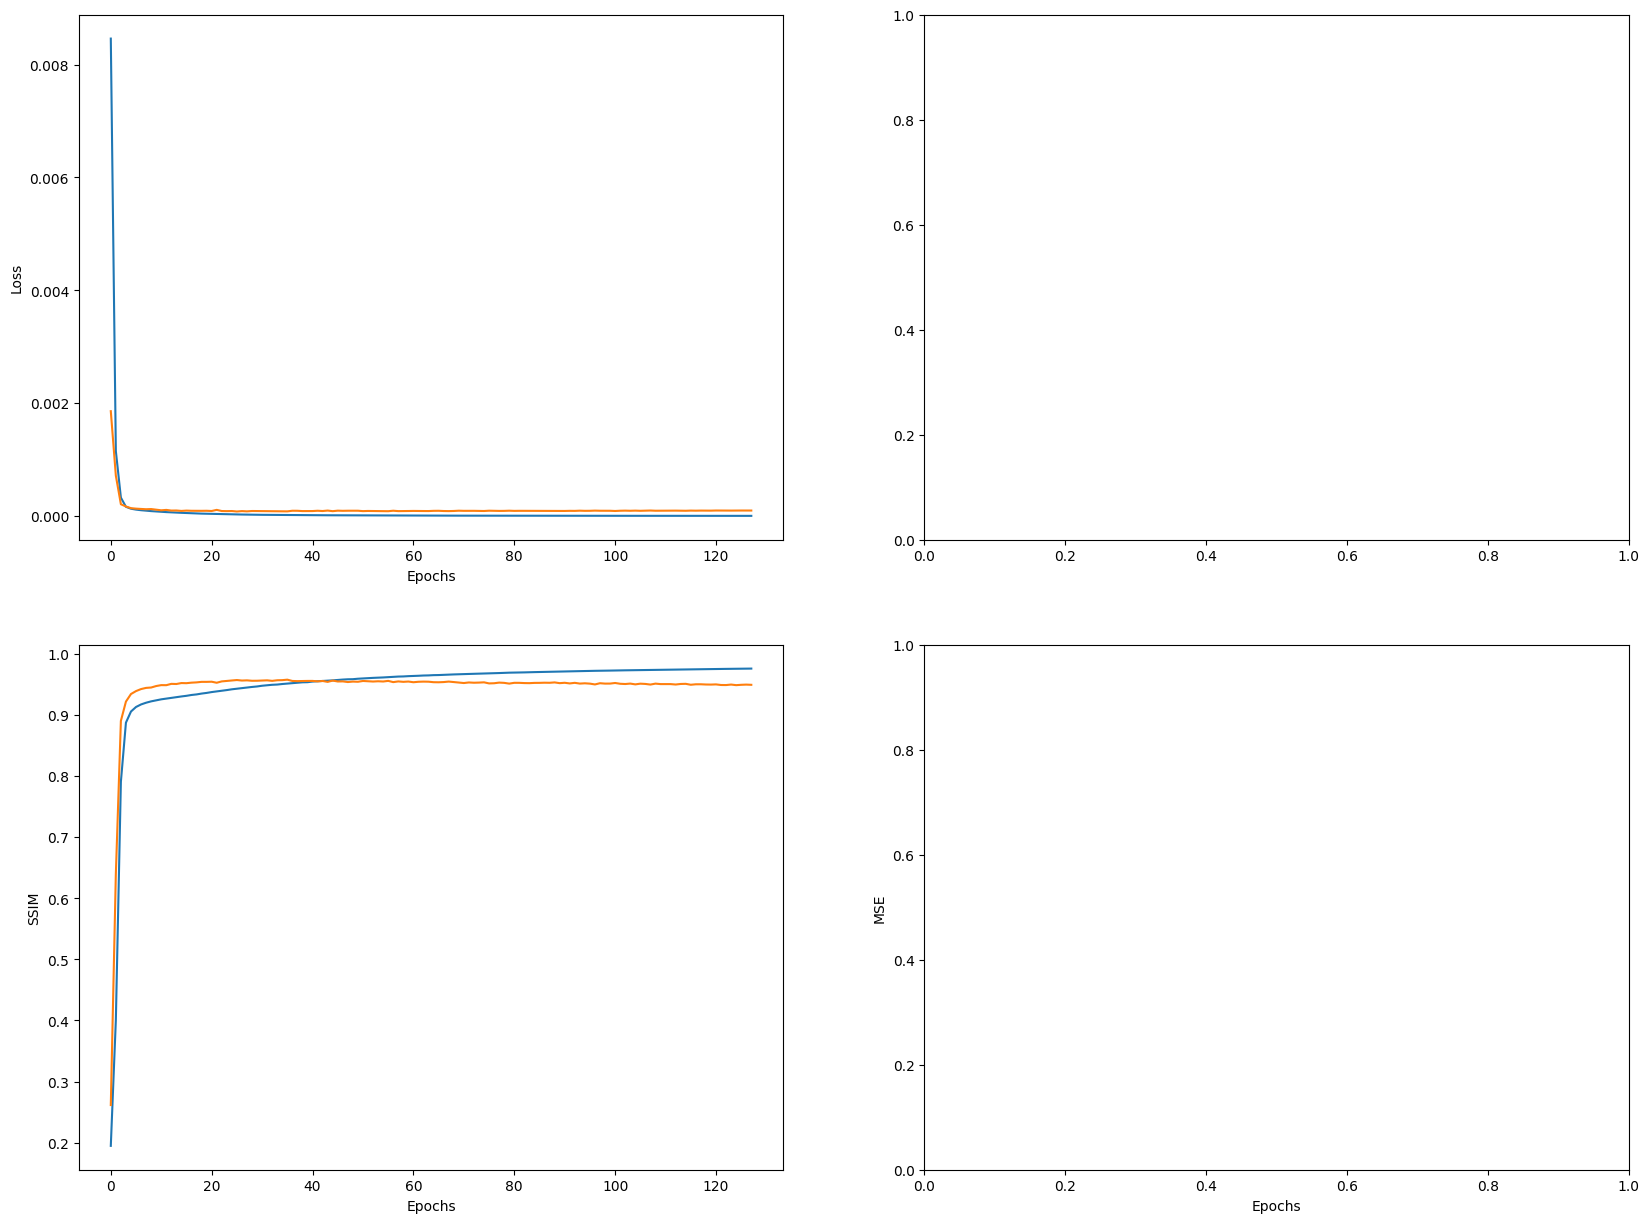

In [22]:
plot_history(history)

In [29]:
unet = UNet()
unet.load_state_dict(torch.load(f"{bn_dssim_model_dir}/model.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [30]:
predictions_fl = unet(images)

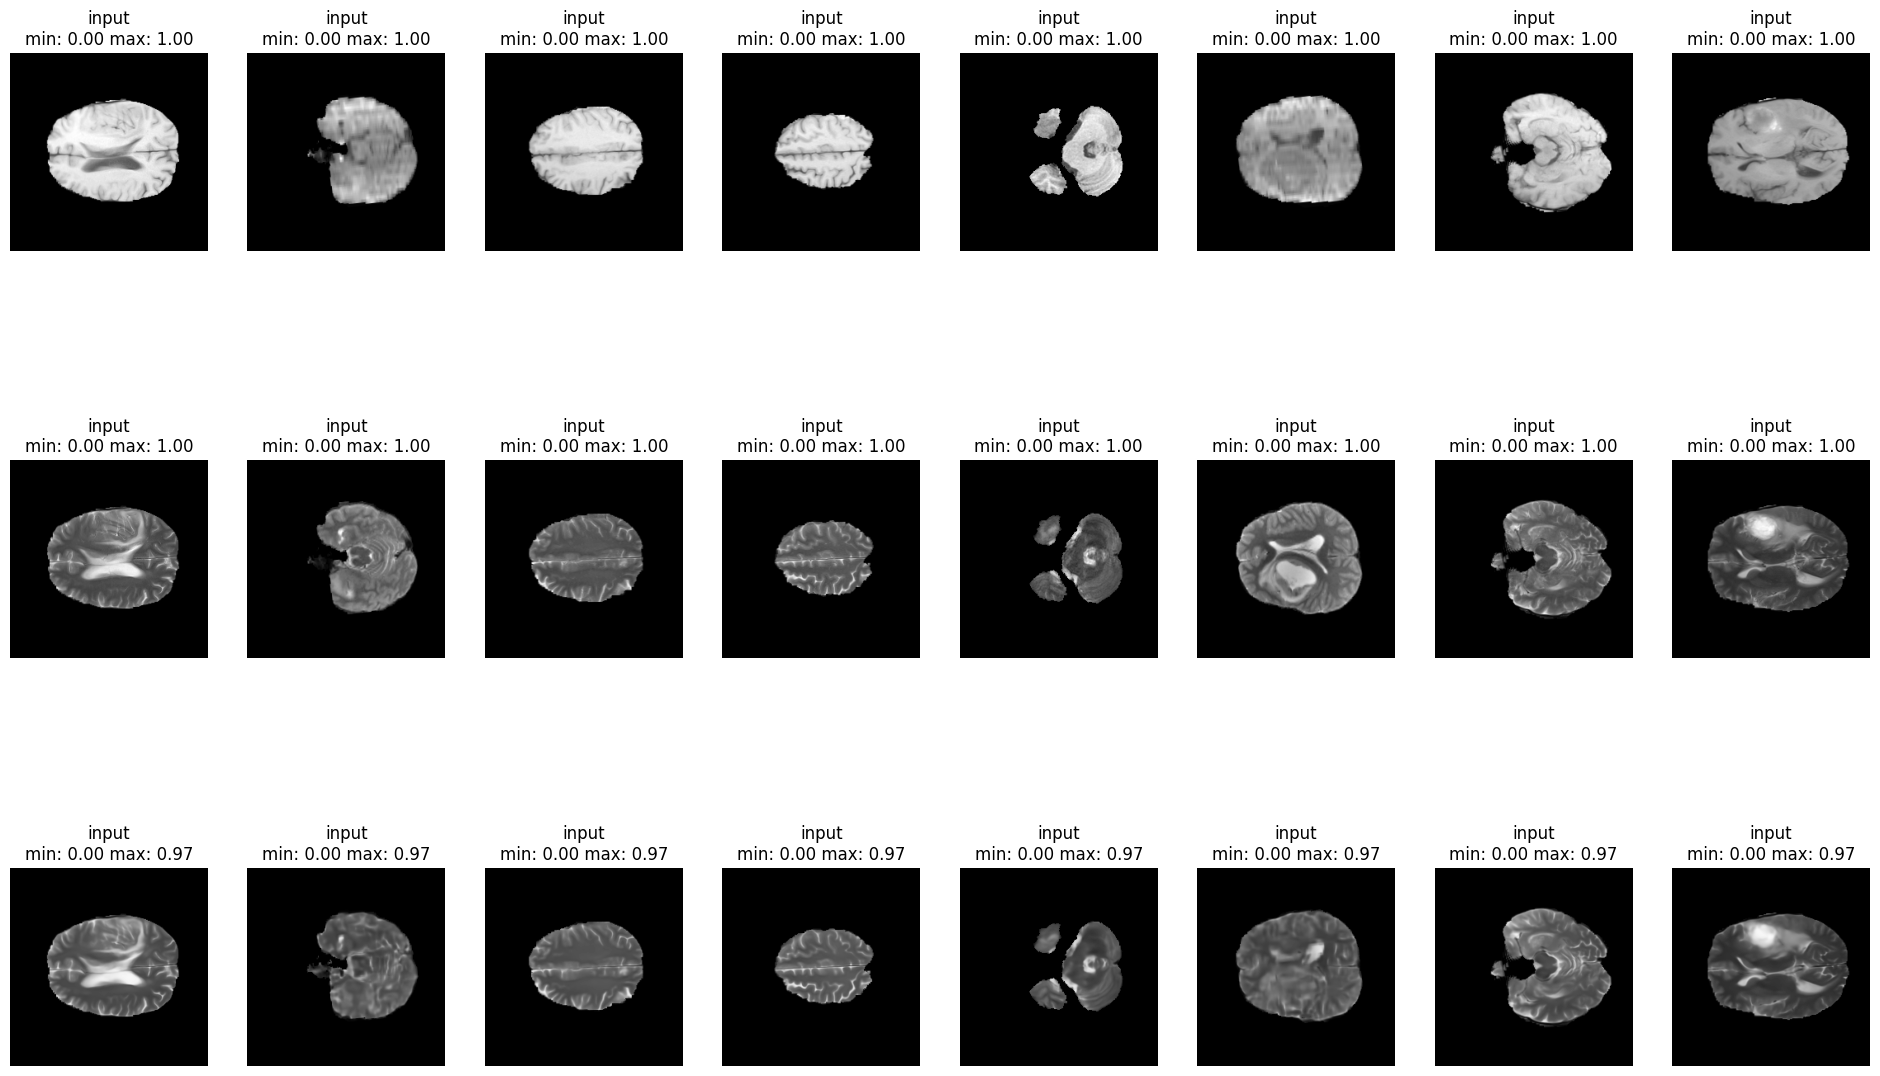

In [31]:
visualization.plot_batch([images, labels, predictions_fl.detach()])